# Receivers & Running Backs EDA & Hypothesis Testing

What makes a prospect a pick? I've collected all this data but what will really matter when predicting a round a prospect will be picked in. I know I want to model based for each of the following position groups:

        * Quarterbacks (QBs)
        * Receivers & Running Backs (Receivers)
        * Offensive Line (OffensiveLine)
        * Linebackers (LBs)
        * Defensive Backs (DefensiveBacks)
        * Special Teams (SpecialTeams)
        
Before I start modeling, I want to check out my data and get to know what will matter when trying to nail down just which round a prospect will be selected in. I start by visualizing the distribution of my outcome in a given position group. From there I pass each variable I think I may want in my model.

In this notebook, I look into my Receivers & Runningbacks data.

First things first, I need to load in my models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import scipy.stats as stats
import scipy

import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# setting format for readability
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df = pd.read_pickle('cleaned_df')

In [4]:
df.head()

,PlayerName,Position,School,CombineYear,Height,Weight,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle,Draft Team,Round,Pick,Draft Year,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Solo_TacklesperGame,Assisted_TacklesperGame,Ttl_TacklesperGame,LossperGame,SacksperGame,Defensive_InterceptionsperGame,Def_Int_YdsperGame,Pick_6perGame,Defended_PassesperGame,Recovered_FumblesperGame,Rec_Fumbles_YdsperGame,Fumbles_Returned_TDperGame,Forced_FumblesperGame,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,TD_OtherperGame,Ttl_TDsperGame,TwoPT_ConversionperGame,SafetyperGame,TTL_PointsperGame,Feet,Inches,Pos
0,Shaun Alexander,RB,Alabama,2000,72,218,4.58,0.00,0.00,0.00,0.00,0.00,Seattle Seahawks,1st,19th pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,11.00,302.00,1383.00,4.60,19.00,25.00,323.00,12.90,4.00,327.00,1706.00,5.20,23.00,27.45,125.73,1.73,2.27,29.36,0.36,29.73,155.09,2.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,24.00,0.00,0.00,144.00,0.00,2.18,0.00,0.00,13.09,72,0,Receivers
1,LaVar Arrington,OLB,Penn State,2000,75,250,4.53,0.00,0.00,0.00,0.00,0.00,Washington Redskins,1st,2nd pick,2000,12.00,0.00,0.00,0.00,0.00,0.00,1.00,27.00,27.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,2.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,3,LBs
2,John Baker,P,North Texas,2000,75,227,0.00,0.00,0.00,0.00,0.00,0.00,0,Not Drafted,Not Drafted,Not Drafted,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,1.00,1.00,100.00,27.00,27.00,27.00,0.00,0.00,326.80,0.09,0.09,2.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,3,SpecialTeams
3,Anthony Becht,TE,West Virginia,2000,78,270,4.78,33.50,0.00,123.00,6.94,4.08,New York Jets,1st,27th pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0

## Functions

This is a lot of repetition so I build function to streamline the process over the 6 groups I need to investigate.

In [5]:
def position_family_df(position_family, df):
    """
    This funciton will filter for the specific position group - or family - I'm interested in for a 
    particular notebook. 
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
        
    Returns:
        dataframe: filtered dataframe
        
    """
    dataframe = df[df['Pos'] == position_family]
    return dataframe

In [6]:
def plot_outcomes(position_family, df):
    """
    This function returns the count for each round a given position group has and graphs it. Along with the count,
    it will also print the normalized count -- % to total -- as a point of comparison.
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
    
    Returns:
        Dataframe shape, value counts for each round and the countplot for the distribution
        
    """
    dataframe = df
    print(position_family + ' Count: ')
    print('-'*40)
    print(position_family + ' Shape: ', dataframe.shape)
    print(dataframe['Round'].value_counts())
    print(round(dataframe['Round'].value_counts(normalize=True), 2))
    order = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', 'Not Drafted']
    plt.figure(figsize=(10, 6))
    sns.countplot(dataframe['Round'],order=order, palette='bright');
    plt.title(position_family + ' Round Distribution')
    plt.savefig(position_family + '_round_distro')
    plt.show()

In [7]:
def plot_stats(position_family, df, lst):
    """
    The function returns the descriptive statistics for each item in a list. The list in question is a set of 
    feature I'm parsing through to determine if they're statistically significant. I want to first check their 
    distribution by plotting each feature's boxplot.
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
        lst: feature list
        
    Returns:
        Prints descriptive statistics, mean by Round for the feature and plots the distribution boxplot.
    
    """
    for i in lst:
        dataframe = df
        order = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', 'Not Drafted']
        print(position_family + ' ' + i + ' Summary:')
        print(dataframe[i].describe())
        print('-' * 40)
        print(position_family + ' ' + i + ' by Round')
        print(dataframe[['Round', i]].groupby(['Round']).mean())
        plt.figure(figsize = (10,6))
        plt.title(position_family + ' ' + i + ' Distribution')
        sns.boxplot(y=dataframe[i], x=dataframe['Round'], order=order)
        plt.savefig(position_family + '_' + i + '_Distro')
        plt.show()

In [8]:
def anova_tukey(position_family, df, feature):
    """
    This function runs the ANOVA test checking for significance between a given feature and the output variable along
    with the 
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
        feature: feature being tested  
        
    Returns:
        Prints ANOVA test summary and Tukey-MC analysis
    
    """
    dataframe = df
    anova_rounds = ols(feature + '~Round', data=dataframe).fit()
    anova_rounds
    anova_table = sm.stats.anova_lm(anova_rounds, type=2)
    print(anova_table)
    print('')
    mc = MultiComparison(dataframe[feature], dataframe['Round'])
    mc_results = mc.tukeyhsd()
    print(mc_results.summary())

## EDA & Hypothesis Testing

In [9]:
receivers_df = position_family_df('Receivers', df)
receivers_df.head()

,PlayerName,Position,School,CombineYear,Height,Weight,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle,Draft Team,Round,Pick,Draft Year,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Solo_TacklesperGame,Assisted_TacklesperGame,Ttl_TacklesperGame,LossperGame,SacksperGame,Defensive_InterceptionsperGame,Def_Int_YdsperGame,Pick_6perGame,Defended_PassesperGame,Recovered_FumblesperGame,Rec_Fumbles_YdsperGame,Fumbles_Returned_TDperGame,Forced_FumblesperGame,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,TD_OtherperGame,Ttl_TDsperGame,TwoPT_ConversionperGame,SafetyperGame,TTL_PointsperGame,Feet,Inches,Pos
0,Shaun Alexander,RB,Alabama,2000,72,218,4.58,0.00,0.00,0.00,0.00,0.00,Seattle Seahawks,1st,19th pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,11.00,302.00,1383.00,4.60,19.00,25.00,323.00,12.90,4.00,327.00,1706.00,5.20,23.00,27.45,125.73,1.73,2.27,29.36,0.36,29.73,155.09,2.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,24.00,0.00,0.00,144.00,0.00,2.18,0.00,0.00,13.09,72,0,Receivers
3,Anthony Becht,TE,West Virginia,2000,78,270,4.78,33.50,0.00,123.00,6.94,4.08,New York Jets,1st,27th pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,5.00,0.00,0.00,30.00,0.00,0.45,0.00,0.00,2.73,72,6,Receivers
8,Plaxico Burress,WR,Michigan State,2000,77,231,4.59,33.00,0.00,115.00,0.00,0.00,Pittsburgh Steelers,1st,8th pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00,1.00,1.00,100.00,7.00,7.00,7.00,0.00,0.00,158.80,0.08,0.08,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00,0.00,12.00,0.00,0.00,72.00,0.00,1.00,0.00,0.00,6.00,72,5,Receivers
9,Trung Canidate,RB,Arizona,2000,71,193,4.41,0.00,18.00,0.00,0.00,0.00,St. Louis Rams,1st,31st pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0

Receivers Count: 
----------------------------------------
Receivers Shape:  (1812, 121)
Not Drafted    640
4th            201
3rd            186
2nd            174
7th            161
5th            155
1st            154
6th            141
Name: Round, dtype: int64
Not Drafted   0.35
4th           0.11
3rd           0.10
2nd           0.10
7th           0.09
5th           0.09
1st           0.08
6th           0.08
Name: Round, dtype: float64


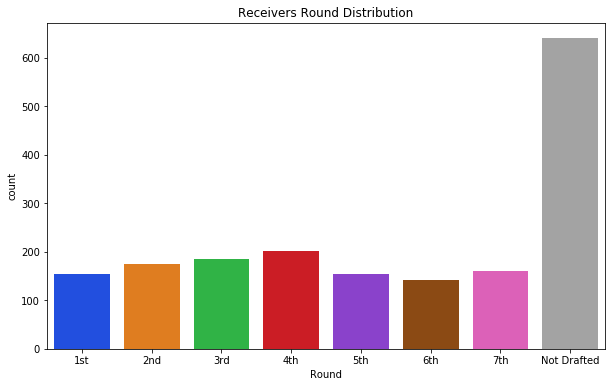

In [10]:
plot_outcomes('Receivers', receivers_df)

### Height & Weight

In [11]:
height_weight = ['Height', 'Weight']

Receivers Height Summary:
count   1812.00
mean      72.70
std        2.75
min       65.00
25%       71.00
50%       73.00
75%       75.00
max       80.00
Name: Height, dtype: float64
----------------------------------------
Receivers Height by Round
             Height
Round              
1st           73.09
2nd           72.86
3rd           73.01
4th           72.54
5th           72.66
6th           72.52
7th           72.75
Not Drafted   72.55


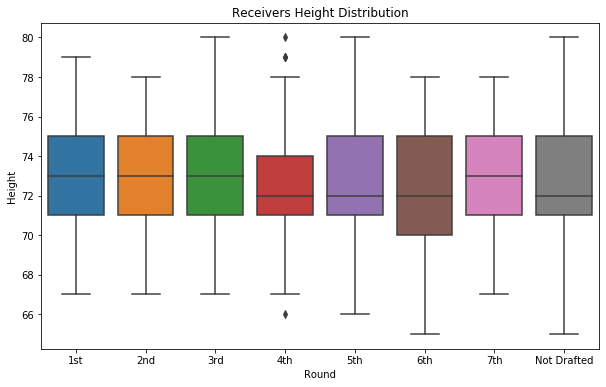

Receivers Weight Summary:
count   1812.00
mean     217.65
std       24.16
min      149.00
25%      200.00
50%      214.00
75%      234.00
max      336.00
Name: Weight, dtype: float64
----------------------------------------
Receivers Weight by Round
             Weight
Round              
1st          218.18
2nd          217.78
3rd          218.92
4th          219.18
5th          218.72
6th          217.06
7th          220.14
Not Drafted  215.89


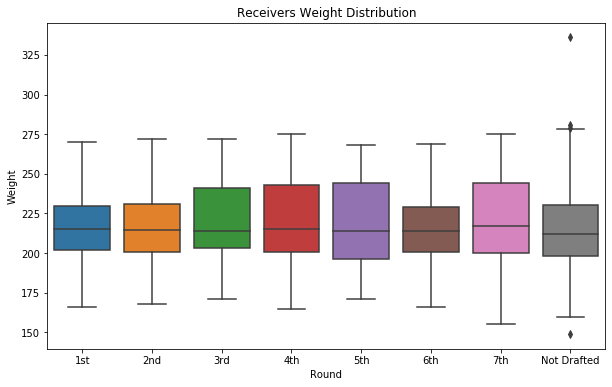

In [12]:
plot_stats('Receivers', receivers_df, height_weight)

In [13]:
anova_tukey('Receivers', receivers_df, 'Height')

              df   sum_sq  mean_sq    F  PR(>F)
Round       7.00    70.43    10.06 1.33    0.23
Residual 1804.00 13632.62     7.56  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.2288    0.9 -1.1517 0.6941  False
   1st         3rd  -0.0855    0.9 -0.9943 0.8233  False
   1st         4th  -0.5486 0.5654 -1.4419 0.3447  False
   1st         5th  -0.4264 0.8641 -1.3755 0.5227  False
   1st         6th  -0.5732   0.61 -1.5455 0.3991  False
   1st         7th  -0.3394    0.9 -1.2796 0.6009  False
   1st Not Drafted  -0.5425 0.3537 -1.2912 0.2062  False
   2nd         3rd   0.1433    0.9 -0.7365 1.0231  False
   2nd         4th  -0.3198    0.9 -1.1835  0.544  False
   2nd         5th  -0.1976    0.9 -1.1189 0.7238  False
   2nd         6th  -0.3443    0.9 -1.2895 0.6009  False
   2nd         7th  -0.1105    0.9 -1.0227 0.8017  False


In [14]:
anova_tukey('Receivers', receivers_df, 'Weight')

              df     sum_sq  mean_sq    F  PR(>F)
Round       7.00    4023.34   574.76 0.98    0.44
Residual 1804.00 1053349.62   583.90  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1    group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------
   1st         2nd   -0.406    0.9  -8.5183  7.7064  False
   1st         3rd   0.7375    0.9   -7.251  8.7261  False
   1st         4th   0.9973    0.9  -6.8551  8.8497  False
   1st         5th   0.5343    0.9  -7.8082  8.8769  False
   1st         6th  -1.1251    0.9  -9.6716  7.4214  False
   1st         7th    1.961    0.9  -6.3037 10.2258  False
   1st Not Drafted  -2.2912    0.9  -8.8724    4.29  False
   2nd         3rd   1.1435    0.9  -6.5898  8.8768  False
   2nd         4th   1.4032    0.9  -6.1893  8.9958  False
   2nd         5th   0.9403    0.9  -7.1582  9.0387  False
   2nd         6th  -0.7191    0.9  -9.0275  7.5893  False
   2nd         7th    2

### Combine Stats

In [15]:
combine_columns = receivers_df[['_40yd', 'Vertical', 'Bench', 'BroadJump', '_3Cone', 'Shuttle']]
combine_columns.describe()

,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle
count,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00
mean,4.43,27.73,11.73,93.03,4.37,2.69
std,0.85,14.03,9.62,48.97,3.44,2.07
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.47,29.50,0.00,108.00,0.00,0.00
50%,4.56,33.50,14.00,116.00,6.86,4.13
75%,4.66,36.00,19.00,121.00,7.10,4.31
max,5.31,45.00,37.00,141.00,8.38,4.85


In [16]:
receivers_combine_stats = ['_40yd', 'Vertical', 'Bench', 'BroadJump', '_3Cone', 'Shuttle']

Receivers _40yd Summary:
count   1812.00
mean       4.43
std        0.85
min        0.00
25%        4.47
50%        4.56
75%        4.66
max        5.31
Name: _40yd, dtype: float64
----------------------------------------
Receivers _40yd by Round
             _40yd
Round             
1st           4.33
2nd           4.32
3rd           4.37
4th           4.51
5th           4.41
6th           4.41
7th           4.53
Not Drafted   4.45


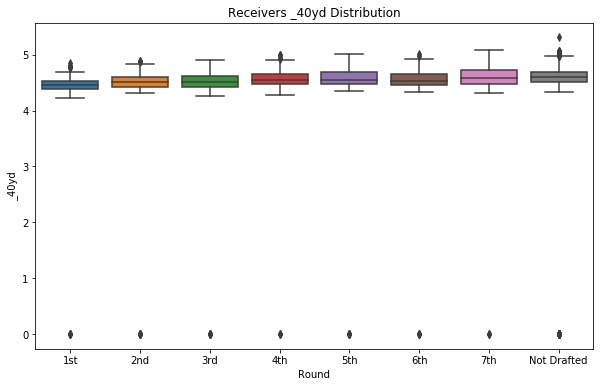

Receivers Vertical Summary:
count   1812.00
mean      27.73
std       14.03
min        0.00
25%       29.50
50%       33.50
75%       36.00
max       45.00
Name: Vertical, dtype: float64
----------------------------------------
Receivers Vertical by Round
             Vertical
Round                
1st             23.37
2nd             26.96
3rd             27.40
4th             29.64
5th             30.30
6th             30.39
7th             27.27
Not Drafted     27.39


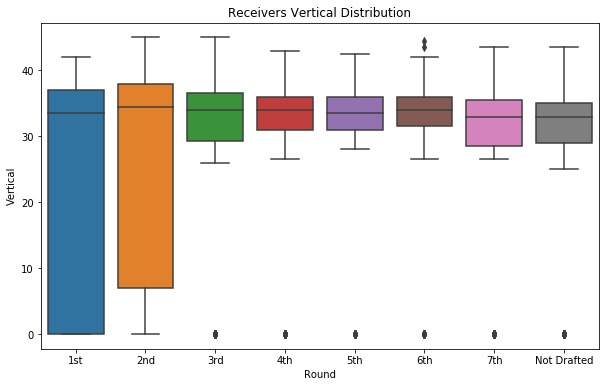

Receivers Bench Summary:
count   1812.00
mean      11.73
std        9.62
min        0.00
25%        0.00
50%       14.00
75%       19.00
max       37.00
Name: Bench, dtype: float64
----------------------------------------
Receivers Bench by Round
             Bench
Round             
1st           9.07
2nd          12.37
3rd          11.81
4th          12.11
5th          12.92
6th          12.38
7th          12.30
Not Drafted  11.47


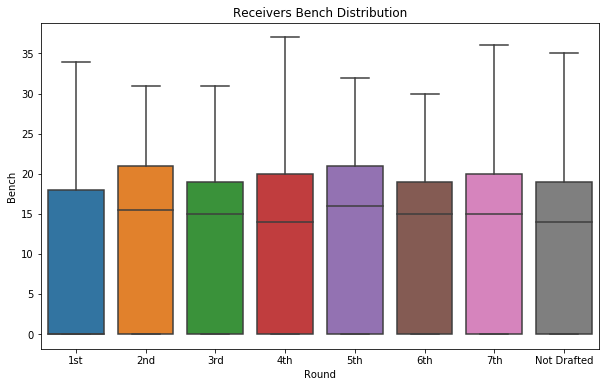

Receivers BroadJump Summary:
count   1812.00
mean      93.03
std       48.97
min        0.00
25%      108.00
50%      116.00
75%      121.00
max      141.00
Name: BroadJump, dtype: float64
----------------------------------------
Receivers BroadJump by Round
             BroadJump
Round                 
1st              75.98
2nd              88.43
3rd              91.88
4th              98.95
5th             103.30
6th             101.17
7th              88.76
Not Drafted      93.64


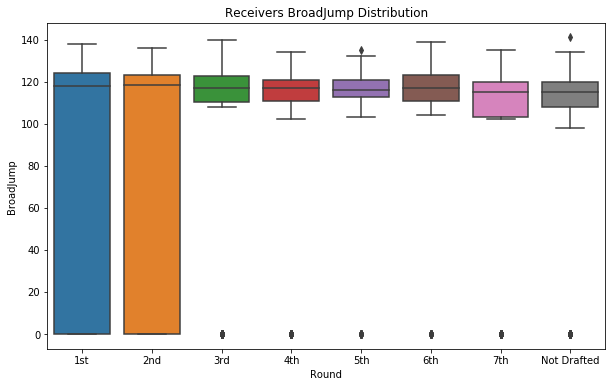

Receivers _3Cone Summary:
count   1812.00
mean       4.37
std        3.44
min        0.00
25%        0.00
50%        6.86
75%        7.10
max        8.38
Name: _3Cone, dtype: float64
----------------------------------------
Receivers _3Cone by Round
             _3Cone
Round              
1st            2.66
2nd            4.14
3rd            4.10
4th            4.78
5th            4.87
6th            5.01
7th            4.71
Not Drafted    4.44


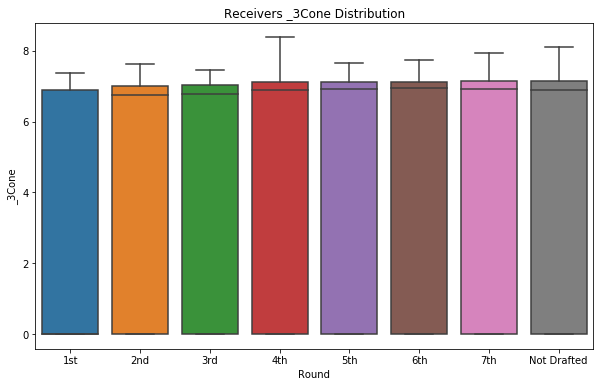

Receivers Shuttle Summary:
count   1812.00
mean       2.69
std        2.07
min        0.00
25%        0.00
50%        4.13
75%        4.31
max        4.85
Name: Shuttle, dtype: float64
----------------------------------------
Receivers Shuttle by Round
             Shuttle
Round               
1st             1.76
2nd             2.63
3rd             2.60
4th             2.85
5th             2.96
6th             2.94
7th             2.81
Not Drafted     2.75


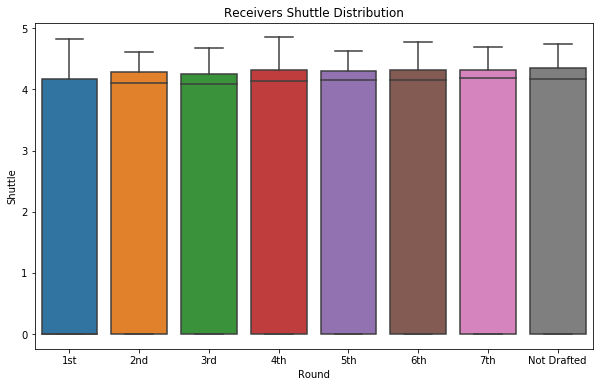

In [17]:
plot_stats('Receivers', receivers_df, receivers_combine_stats)

In [18]:
for i in receivers_combine_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Receivers', receivers_df, i)
    print('')
    print('*' * 60)

_40yd ANOVA Test:
----------------------------------------
              df  sum_sq  mean_sq    F  PR(>F)
Round       7.00    7.29     1.04 1.43    0.19
Residual 1804.00 1312.44     0.73  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0145    0.9 -0.3008 0.2719  False
   1st         3rd   0.0408    0.9 -0.2412 0.3228  False
   1st         4th    0.175 0.5344 -0.1022 0.4521  False
   1st         5th    0.079    0.9 -0.2155 0.3735  False
   1st         6th   0.0791    0.9 -0.2226 0.3807  False
   1st         7th   0.1973 0.4495 -0.0945  0.489  False
   1st Not Drafted   0.1142 0.7876 -0.1181 0.3465  False
   2nd         3rd   0.0553    0.9 -0.2177 0.3282  False
   2nd         4th   0.1894 0.3883 -0.0786 0.4574  False
   2nd         5th   0.0935    0.9 -0.1924 0.3793  False
   2nd         6th   0.0935    0.9 -0.1998 0.3868  False
 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   1.4834 0.0021  0.3434 2.6234   True
   1st         3rd   1.4426 0.0025    0.32 2.5652   True
   1st         4th   2.1156  0.001  1.0121  3.219   True
   1st         5th   2.2113  0.001   1.039 3.3837   True
   1st         6th   2.3504  0.001  1.1494 3.5514   True
   1st         7th   2.0509  0.001  0.8895 3.2123   True
   1st Not Drafted   1.7756  0.001  0.8507 2.7004   True
   2nd         3rd  -0.0408    0.9 -1.1275 1.0459  False
   2nd         4th   0.6322 0.6046 -0.4347 1.6992  False
   2nd         5th    0.728 0.5192 -0.4101  1.866  False
   2nd         6th    0.867 0.3203 -0.3005 2.0346  False
   2nd         7th   0.5676 0.7655 -0.5592 1.6944  False
   2nd Not Drafted   0.2922    0.9 -0.5887 1.1732  False
   3rd         4th    0.673  0.515 -0.3753 1.7213  False
   3rd         5th   0.7688 0.4

### College Stats - Passing

In [20]:
passing_stats = ['Passing_Games', 'Completions', 'Pass_Attempts', 'Completion_Percent', 'Pass_Yards', 
                 'Pass_Yds_per_Attempt', 'Adj_Pass_Yds_per_Attempt', 'Pass_TDs', 'Pass_Interceptions', 'Passer_Rating', 
                 'CompletionsperGame', 'Pass_AttemptsperGame', 'Pass_YardsperGame', 'Pass_TDsperGame', 
                 'Pass_InterceptionsperGame']

In [21]:
receivers_df[passing_stats].describe()

,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame
count,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00
mean,3.12,1.29,2.28,7.84,17.54,1.59,1.82,0.17,0.09,30.58,0.11,0.19,1.48,0.01,0.01
std,5.28,14.29,24.11,24.62,176.42,6.24,9.43,1.30,0.84,116.30,1.19,2.01,14.78,0.11,0.07
min,0.00,0.00,0.00,0.00,-6.00,-2.00,-45.00,0.00,0.00,-200.00,0.00,0.00,-0.55,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,9.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,15.00,319.00,469.00,100.00,3557.00,81.00,101.00,22.00,14.00,1110.40,26.58,39.08,296.42,1.83,1.09


Receivers Passing_Games Summary:
count   1812.00
mean       3.12
std        5.28
min        0.00
25%        0.00
50%        0.00
75%        9.00
max       15.00
Name: Passing_Games, dtype: float64
----------------------------------------
Receivers Passing_Games by Round
             Passing_Games
Round                     
1st                   3.95
2nd                   3.61
3rd                   3.24
4th                   2.94
5th                   3.24
6th                   2.56
7th                   2.76
Not Drafted           2.99


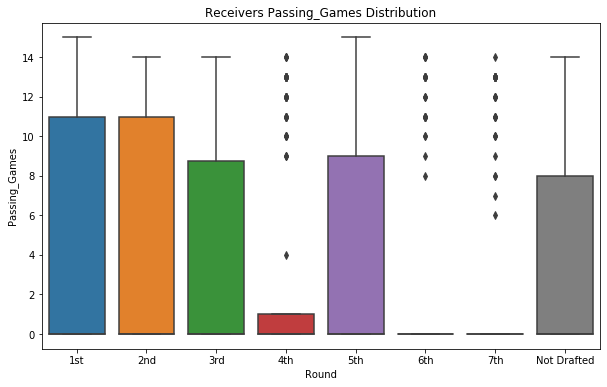

Receivers Completions Summary:
count   1812.00
mean       1.29
std       14.29
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      319.00
Name: Completions, dtype: float64
----------------------------------------
Receivers Completions by Round
             Completions
Round                   
1st                 1.18
2nd                 0.92
3rd                 0.92
4th                 2.08
5th                 2.79
6th                 0.09
7th                 0.40
Not Drafted         1.40


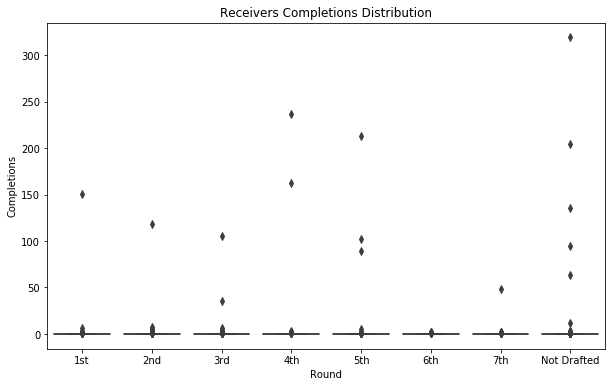

Receivers Pass_Attempts Summary:
count   1812.00
mean       2.28
std       24.11
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      469.00
Name: Pass_Attempts, dtype: float64
----------------------------------------
Receivers Pass_Attempts by Round
             Pass_Attempts
Round                     
1st                   2.10
2nd                   1.91
3rd                   1.69
4th                   3.77
5th                   4.71
6th                   0.18
7th                   0.76
Not Drafted           2.38


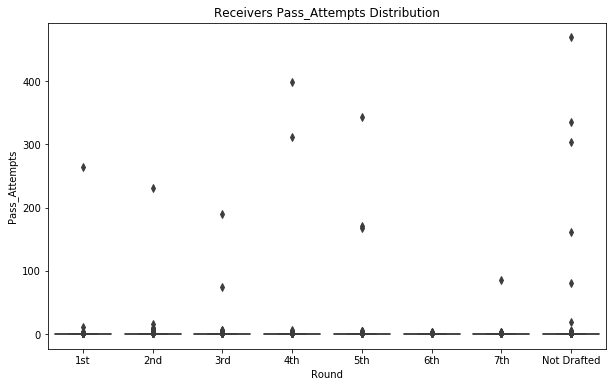

Receivers Completion_Percent Summary:
count   1812.00
mean       7.84
std       24.62
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      100.00
Name: Completion_Percent, dtype: float64
----------------------------------------
Receivers Completion_Percent by Round
             Completion_Percent
Round                          
1st                       11.11
2nd                        8.00
3rd                        9.35
4th                        5.94
5th                       11.23
6th                        5.91
7th                        7.08
Not Drafted                6.98


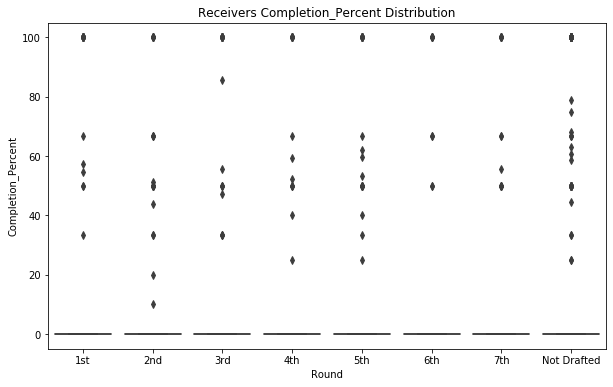

Receivers Pass_Yards Summary:
count   1812.00
mean      17.54
std      176.42
min       -6.00
25%        0.00
50%        0.00
75%        0.00
max     3557.00
Name: Pass_Yards, dtype: float64
----------------------------------------
Receivers Pass_Yards by Round
             Pass_Yards
Round                  
1st               18.72
2nd               14.19
3rd               12.99
4th               25.32
5th               37.16
6th                1.72
7th                8.52
Not Drafted       18.06


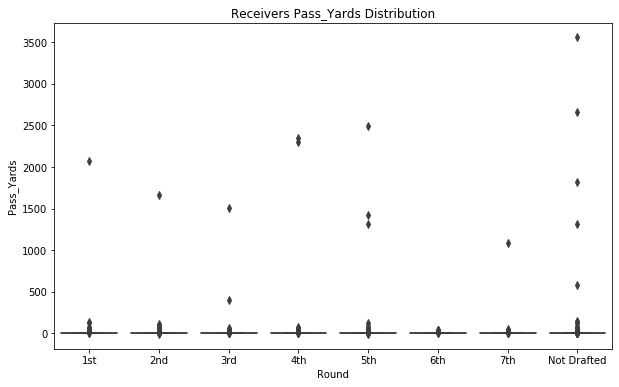

Receivers Pass_Yds_per_Attempt Summary:
count   1812.00
mean       1.59
std        6.24
min       -2.00
25%        0.00
50%        0.00
75%        0.00
max       81.00
Name: Pass_Yds_per_Attempt, dtype: float64
----------------------------------------
Receivers Pass_Yds_per_Attempt by Round
             Pass_Yds_per_Attempt
Round                            
1st                          2.90
2nd                          1.80
3rd                          1.74
4th                          1.33
5th                          1.57
6th                          1.07
7th                          1.12
Not Drafted                  1.50


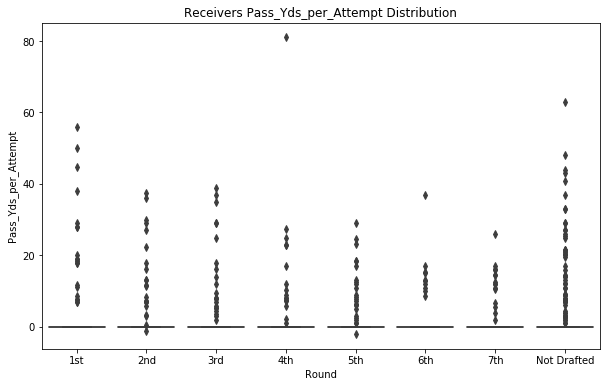

Receivers Adj_Pass_Yds_per_Attempt Summary:
count   1812.00
mean       1.82
std        9.43
min      -45.00
25%        0.00
50%        0.00
75%        0.00
max      101.00
Name: Adj_Pass_Yds_per_Attempt, dtype: float64
----------------------------------------
Receivers Adj_Pass_Yds_per_Attempt by Round
             Adj_Pass_Yds_per_Attempt
Round                                
1st                              3.28
2nd                              1.65
3rd                              2.24
4th                              1.85
5th                              1.99
6th                              0.93
7th                              1.85
Not Drafted                      1.53


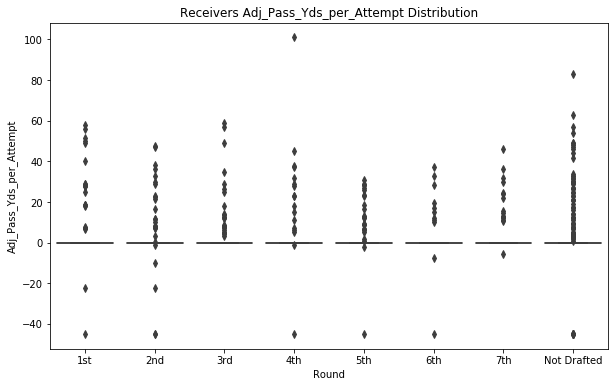

Receivers Pass_TDs Summary:
count   1812.00
mean       0.17
std        1.30
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       22.00
Name: Pass_TDs, dtype: float64
----------------------------------------
Receivers Pass_TDs by Round
             Pass_TDs
Round                
1st              0.19
2nd              0.13
3rd              0.10
4th              0.21
5th              0.32
6th              0.03
7th              0.11
Not Drafted      0.18


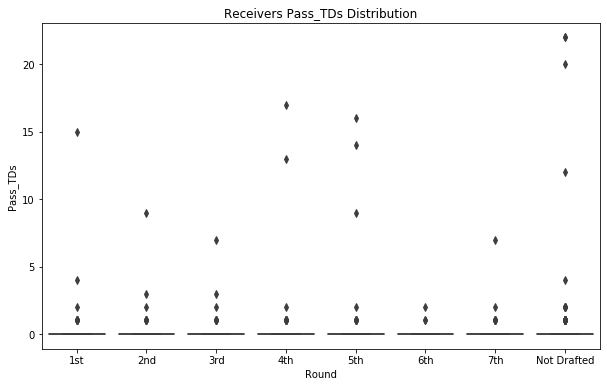

Receivers Pass_Interceptions Summary:
count   1812.00
mean       0.09
std        0.84
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       14.00
Name: Pass_Interceptions, dtype: float64
----------------------------------------
Receivers Pass_Interceptions by Round
             Pass_Interceptions
Round                          
1st                        0.09
2nd                        0.06
3rd                        0.07
4th                        0.11
5th                        0.18
6th                        0.01
7th                        0.02
Not Drafted                0.10


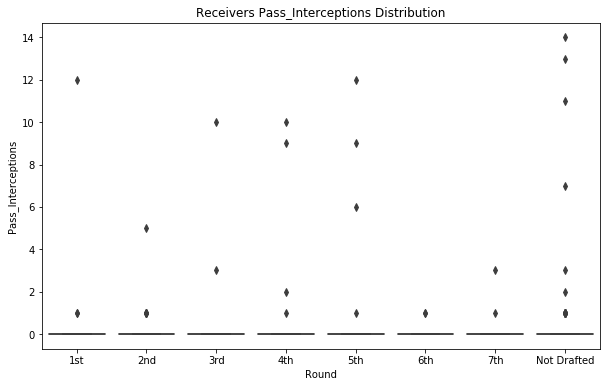

Receivers Passer_Rating Summary:
count   1812.00
mean      30.58
std      116.30
min     -200.00
25%        0.00
50%        0.00
75%        0.00
max     1110.40
Name: Passer_Rating, dtype: float64
----------------------------------------
Receivers Passer_Rating by Round
             Passer_Rating
Round                     
1st                  47.23
2nd                  30.58
3rd                  32.55
4th                  29.48
5th                  35.26
6th                  18.27
7th                  30.35
Not Drafted          27.97


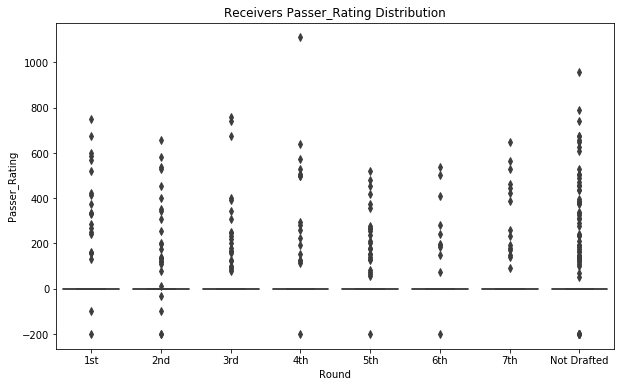

Receivers CompletionsperGame Summary:
count   1812.00
mean       0.11
std        1.19
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       26.58
Name: CompletionsperGame, dtype: float64
----------------------------------------
Receivers CompletionsperGame by Round
             CompletionsperGame
Round                          
1st                        0.11
2nd                        0.08
3rd                        0.08
4th                        0.17
5th                        0.25
6th                        0.01
7th                        0.03
Not Drafted                0.11


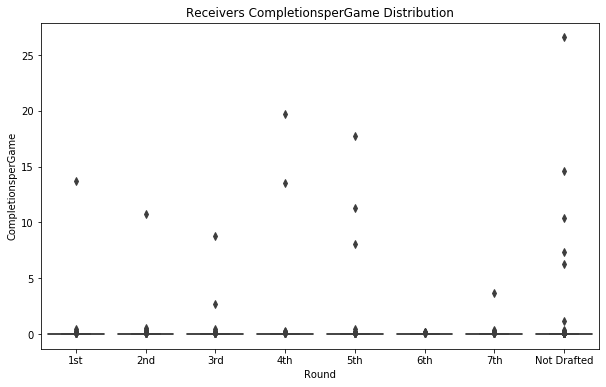

Receivers Pass_AttemptsperGame Summary:
count   1812.00
mean       0.19
std        2.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       39.08
Name: Pass_AttemptsperGame, dtype: float64
----------------------------------------
Receivers Pass_AttemptsperGame by Round
             Pass_AttemptsperGame
Round                            
1st                          0.19
2nd                          0.17
3rd                          0.14
4th                          0.31
5th                          0.43
6th                          0.02
7th                          0.06
Not Drafted                  0.19


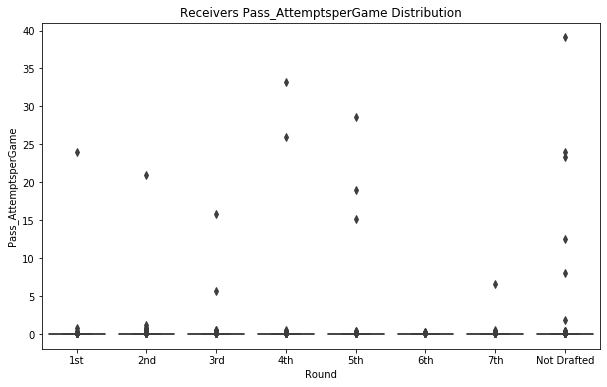

Receivers Pass_YardsperGame Summary:
count   1812.00
mean       1.48
std       14.78
min       -0.55
25%        0.00
50%        0.00
75%        0.00
max      296.42
Name: Pass_YardsperGame, dtype: float64
----------------------------------------
Receivers Pass_YardsperGame by Round
             Pass_YardsperGame
Round                         
1st                       1.68
2nd                       1.24
3rd                       1.07
4th                       2.11
5th                       3.41
6th                       0.14
7th                       0.68
Not Drafted               1.45


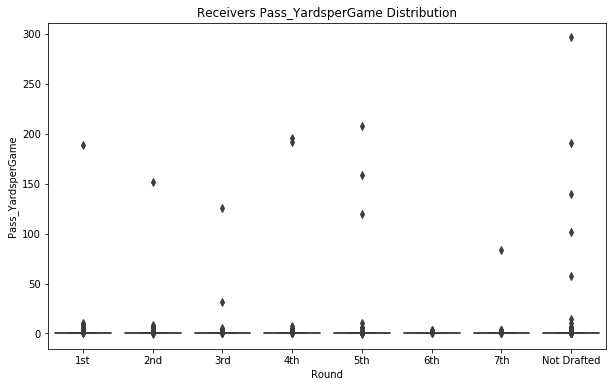

Receivers Pass_TDsperGame Summary:
count   1812.00
mean       0.01
std        0.11
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.83
Name: Pass_TDsperGame, dtype: float64
----------------------------------------
Receivers Pass_TDsperGame by Round
             Pass_TDsperGame
Round                       
1st                     0.02
2nd                     0.01
3rd                     0.01
4th                     0.02
5th                     0.03
6th                     0.00
7th                     0.01
Not Drafted             0.01


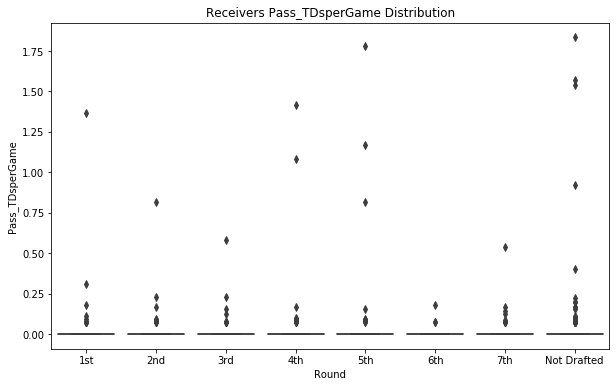

Receivers Pass_InterceptionsperGame Summary:
count   1812.00
mean       0.01
std        0.07
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.09
Name: Pass_InterceptionsperGame, dtype: float64
----------------------------------------
Receivers Pass_InterceptionsperGame by Round
             Pass_InterceptionsperGame
Round                                 
1st                               0.01
2nd                               0.01
3rd                               0.01
4th                               0.01
5th                               0.02
6th                               0.00
7th                               0.00
Not Drafted                       0.01


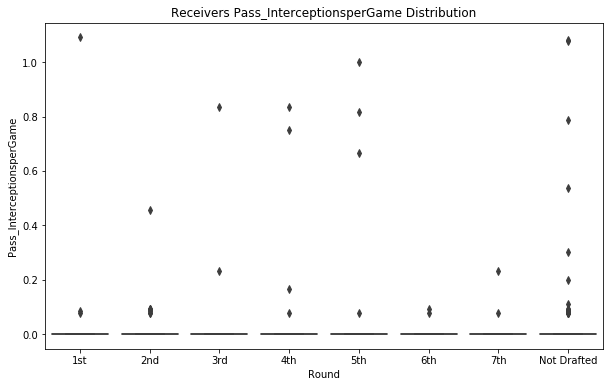

In [22]:
plot_stats('Receivers', receivers_df, passing_stats)

In [23]:
for i in passing_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Receivers', receivers_df, i)
    print('')
    print('*' * 40)

Passing_Games ANOVA Test:
----------------------------------------
              df   sum_sq  mean_sq    F  PR(>F)
Round       7.00   236.82    33.83 1.21    0.29
Residual 1804.00 50257.71    27.86  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.3396    0.9 -2.1116 1.4324  False
   1st         3rd  -0.7126    0.9 -2.4576 1.0323  False
   1st         4th  -1.0142 0.6068 -2.7295  0.701  False
   1st         5th  -0.7158    0.9 -2.5381 1.1064  False
   1st         6th  -1.3943  0.313 -3.2611 0.4726  False
   1st         7th  -1.1968 0.4757 -3.0021 0.6085  False
   1st Not Drafted  -0.9608 0.4651 -2.3983 0.4767  False
   2nd         3rd   -0.373    0.9 -2.0622 1.3162  False
   2nd         4th  -0.6746    0.9 -2.3331 0.9838  False
   2nd         5th  -0.3762    0.9 -2.1452 1.3927  False
   2nd         6th  -1.0547 0.6252 -2.8695 0.76

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -1.1013  0.725 -3.1948 0.9922  False
   1st         3rd  -1.1588 0.6597 -3.2204 0.9027  False
   1st         4th  -1.5695 0.2671 -3.5959  0.457  False
   1st         5th  -1.3342 0.5553 -3.4871 0.8187  False
   1st         6th  -1.8268 0.1901 -4.0324 0.3787  False
   1st         7th  -1.7796 0.1824 -3.9124 0.3533  False
   1st Not Drafted  -1.4032 0.1928 -3.1016 0.2952  False
   2nd         3rd  -0.0575    0.9 -2.0532 1.9382  False
   2nd         4th  -0.4682    0.9 -2.4275 1.4912  False
   2nd         5th  -0.2329    0.9 -2.3228  1.857  False
   2nd         6th  -0.7255    0.9 -2.8696 1.4186  False
   2nd         7th  -0.6783    0.9 -2.7475  1.391  False
   2nd Not Drafted  -0.3019    0.9 -1.9197 1.3159  False
   3rd         4th  -0.4106    0.9 -2.3358 1.5146  False
   3rd         5th  -0.1754    

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0247    0.9 -0.4261 0.3767  False
   1st         3rd  -0.0304    0.9 -0.4256 0.3649  False
   1st         4th   0.0677    0.9 -0.3208 0.4562  False
   1st         5th   0.1492    0.9 -0.2636  0.562  False
   1st         6th  -0.0982    0.9  -0.521 0.3247  False
   1st         7th  -0.0726    0.9 -0.4816 0.3363  False
   1st Not Drafted   0.0067    0.9 -0.3189 0.3324  False
   2nd         3rd  -0.0057    0.9 -0.3883 0.3769  False
   2nd         4th   0.0924    0.9 -0.2833  0.468  False
   2nd         5th   0.1738 0.8922 -0.2269 0.5745  False
   2nd         6th  -0.0735    0.9 -0.4846 0.3376  False
   2nd         7th   -0.048    0.9 -0.4447 0.3488  False
   2nd Not Drafted   0.0314    0.9 -0.2788 0.3416  False
   3rd         4th   0.0981    0.9 -0.2711 0.4672  False
   3rd         5th   0.1795 0.8

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0026    0.9 -0.0263 0.0212  False
   1st         3rd  -0.0024    0.9 -0.0258  0.021  False
   1st         4th    0.001    0.9  -0.022 0.0239  False
   1st         5th   0.0084    0.9  -0.016 0.0328  False
   1st         6th  -0.0069    0.9 -0.0319 0.0181  False
   1st         7th  -0.0062    0.9 -0.0304  0.018  False
   1st Not Drafted  -0.0004    0.9 -0.0197 0.0188  False
   2nd         3rd   0.0002    0.9 -0.0224 0.0228  False
   2nd         4th   0.0035    0.9 -0.0187 0.0258  False
   2nd         5th    0.011 0.8381 -0.0127 0.0347  False
   2nd         6th  -0.0044    0.9 -0.0287   0.02  False
   2nd         7th  -0.0036    0.9 -0.0271 0.0198  False
   2nd Not Drafted   0.0021    0.9 -0.0162 0.0205  False
   3rd         4th   0.0034    0.9 -0.0185 0.0252  False
   3rd         5th   0.0108 0.8

### College Stats - Rushing & Receiving

In [24]:
rushing_stats = ['Rush_Rec_Games', 'Rush_Attempts', 'Rush_Yds', 'Rush_Yds_per_Attempt', 'Rush_TDs', 
                 'Receptions', 'Rec_Yds', 'Rec_Yds_per_Reception', 'Rec_TDs', 'Plays_from_Scrimmage', 'Scrimmage_Yds',
                 'Scrimmage_Yds_per_Attempt', 'Scrimmage_TDs', 'Rush_AttemptsperGame', 'Rush_YdsperGame', 
                 'Rush_TDsperGame', 'ReceptionsperGame', 'Rec_YdsperGame', 'Rec_TDsperGame', 
                 'Plays_from_ScrimmageperGame', 'Scrimmage_YdsperGame', 'Scrimmage_TDsperGame']

In [25]:
receivers_df[rushing_stats].describe()

,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame
count,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00
mean,4.07,62.82,336.87,1.83,3.40,6.93,64.94,3.17,0.39,69.76,401.82,2.05,3.80,5.36,28.71,0.29,0.59,5.51,0.03,5.95,34.22,0.32
std,5.66,101.00,554.87,2.60,5.90,12.57,126.30,4.96,1.02,110.07,640.74,2.92,6.42,8.42,46.06,0.49,1.04,10.43,0.09,9.17,53.15,0.53
min,0.00,0.00,-4.00,-4.00,0.00,0.00,-6.00,-1.30,0.00,0.00,0.00,0.00,0.00,0.00,-0.31,0.00,0.00,-0.50,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,11.00,122.00,603.25,4.70,5.00,11.00,85.25,7.10,0.00,139.25,791.25,5.20,7.00,11.42,57.80,0.50,1.00,7.90,0.00,13.08,69.92,0.58
max,15.00,450.00,2587.00,12.40,31.00,98.00,1017.00,63.00,11.00,474.00,2809.00,14.80,32.00,33.55,196.18,3.00,8.36,78.83,0.79,34.45,200.75,3.00


Receivers Rush_Rec_Games Summary:
count   1812.00
mean       4.07
std        5.66
min        0.00
25%        0.00
50%        0.00
75%       11.00
max       15.00
Name: Rush_Rec_Games, dtype: float64
----------------------------------------
Receivers Rush_Rec_Games by Round
             Rush_Rec_Games
Round                      
1st                    3.97
2nd                    4.11
3rd                    3.72
4th                    4.52
5th                    3.70
6th                    4.20
7th                    3.91
Not Drafted            4.13


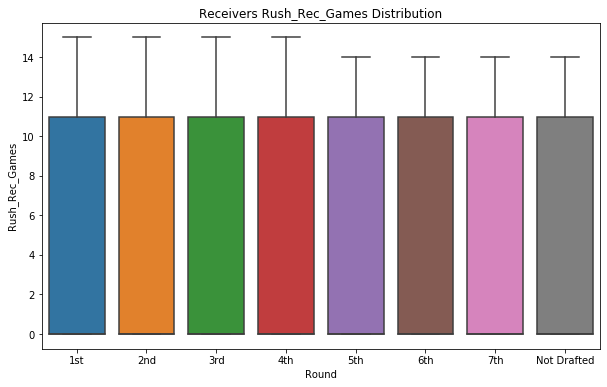

Receivers Rush_Attempts Summary:
count   1812.00
mean      62.82
std      101.00
min        0.00
25%        0.00
50%        0.00
75%      122.00
max      450.00
Name: Rush_Attempts, dtype: float64
----------------------------------------
Receivers Rush_Attempts by Round
             Rush_Attempts
Round                     
1st                  80.37
2nd                  74.58
3rd                  65.75
4th                  70.78
5th                  59.82
6th                  59.12
7th                  53.81
Not Drafted          55.86


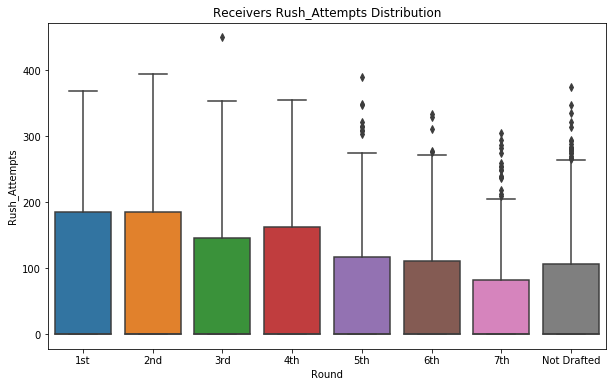

Receivers Rush_Yds Summary:
count   1812.00
mean     336.87
std      554.87
min       -4.00
25%        0.00
50%        0.00
75%      603.25
max     2587.00
Name: Rush_Yds, dtype: float64
----------------------------------------
Receivers Rush_Yds by Round
             Rush_Yds
Round                
1st            481.02
2nd            416.80
3rd            367.38
4th            381.47
5th            321.65
6th            313.45
7th            283.53
Not Drafted    279.85


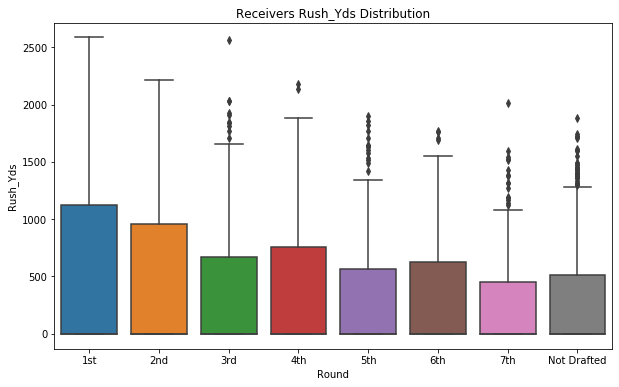

Receivers Rush_Yds_per_Attempt Summary:
count   1812.00
mean       1.83
std        2.60
min       -4.00
25%        0.00
50%        0.00
75%        4.70
max       12.40
Name: Rush_Yds_per_Attempt, dtype: float64
----------------------------------------
Receivers Rush_Yds_per_Attempt by Round
             Rush_Yds_per_Attempt
Round                            
1st                          2.02
2nd                          1.87
3rd                          1.68
4th                          2.06
5th                          1.64
6th                          1.84
7th                          1.75
Not Drafted                  1.82


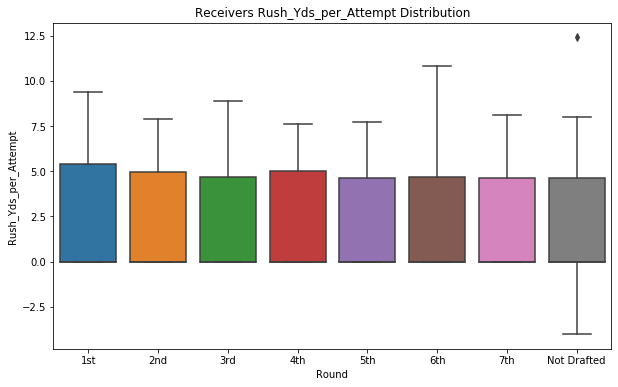

Receivers Rush_TDs Summary:
count   1812.00
mean       3.40
std        5.90
min        0.00
25%        0.00
50%        0.00
75%        5.00
max       31.00
Name: Rush_TDs, dtype: float64
----------------------------------------
Receivers Rush_TDs by Round
             Rush_TDs
Round                
1st              4.97
2nd              4.47
3rd              3.81
4th              3.76
5th              3.25
6th              3.11
7th              2.72
Not Drafted      2.77


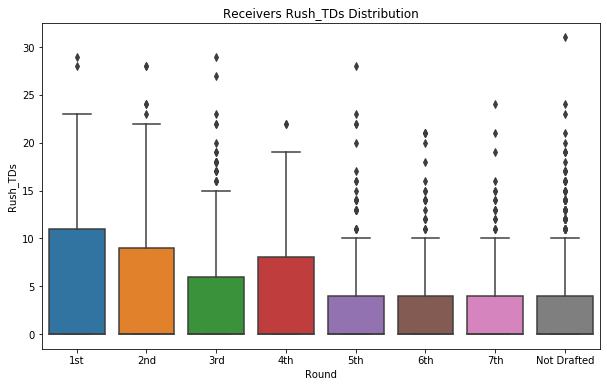

Receivers Receptions Summary:
count   1812.00
mean       6.93
std       12.57
min        0.00
25%        0.00
50%        0.00
75%       11.00
max       98.00
Name: Receptions, dtype: float64
----------------------------------------
Receivers Receptions by Round
             Receptions
Round                  
1st                7.82
2nd                7.75
3rd                6.48
4th                7.59
5th                6.39
6th                6.87
7th                6.65
Not Drafted        6.64


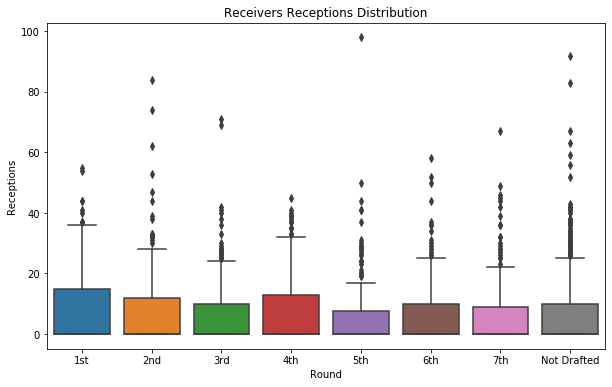

Receivers Rec_Yds Summary:
count   1812.00
mean      64.94
std      126.30
min       -6.00
25%        0.00
50%        0.00
75%       85.25
max     1017.00
Name: Rec_Yds, dtype: float64
----------------------------------------
Receivers Rec_Yds by Round
             Rec_Yds
Round               
1st            78.84
2nd            79.77
3rd            67.09
4th            67.74
5th            61.97
6th            61.87
7th            61.10
Not Drafted    58.43


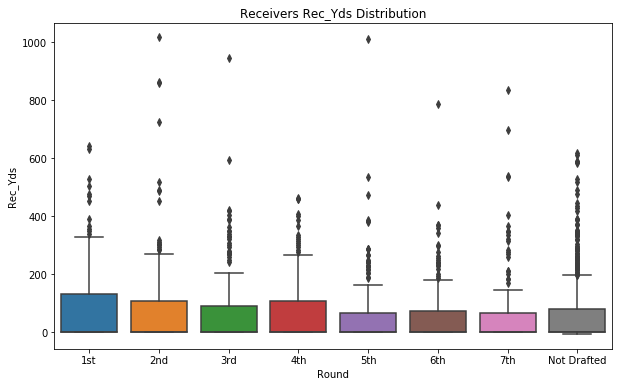

Receivers Rec_Yds_per_Reception Summary:
count   1812.00
mean       3.17
std        4.96
min       -1.30
25%        0.00
50%        0.00
75%        7.10
max       63.00
Name: Rec_Yds_per_Reception, dtype: float64
----------------------------------------
Receivers Rec_Yds_per_Reception by Round
             Rec_Yds_per_Reception
Round                             
1st                           3.14
2nd                           3.27
3rd                           3.37
4th                           3.37
5th                           3.00
6th                           3.32
7th                           2.91
Not Drafted                   3.11


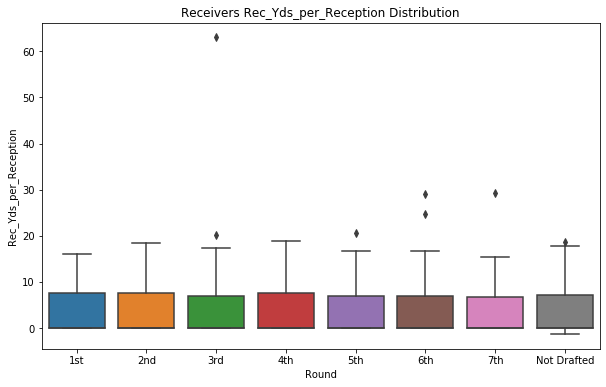

Receivers Rec_TDs Summary:
count   1812.00
mean       0.39
std        1.02
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       11.00
Name: Rec_TDs, dtype: float64
----------------------------------------
Receivers Rec_TDs by Round
             Rec_TDs
Round               
1st             0.55
2nd             0.54
3rd             0.39
4th             0.41
5th             0.32
6th             0.40
7th             0.42
Not Drafted     0.33


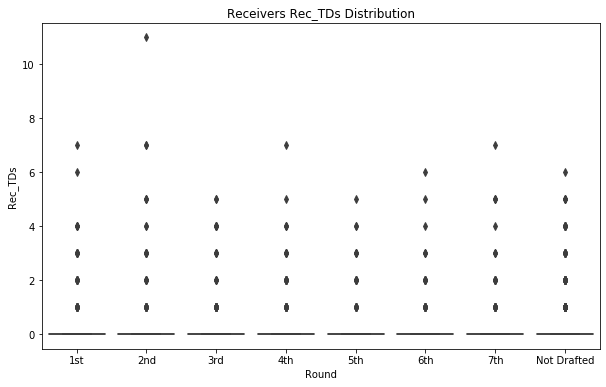

Receivers Plays_from_Scrimmage Summary:
count   1812.00
mean      69.76
std      110.07
min        0.00
25%        0.00
50%        0.00
75%      139.25
max      474.00
Name: Plays_from_Scrimmage, dtype: float64
----------------------------------------
Receivers Plays_from_Scrimmage by Round
             Plays_from_Scrimmage
Round                            
1st                         88.19
2nd                         82.33
3rd                         72.23
4th                         78.36
5th                         66.21
6th                         65.99
7th                         60.47
Not Drafted                 62.50


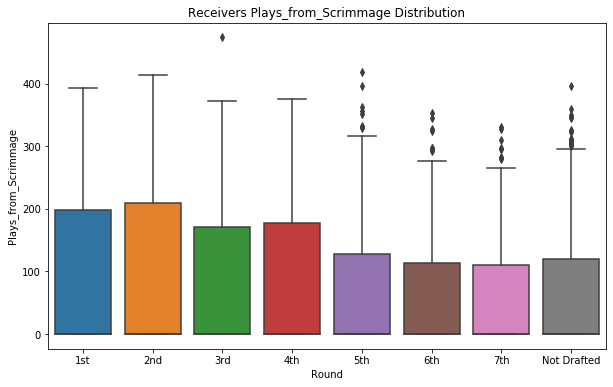

Receivers Scrimmage_Yds Summary:
count   1812.00
mean     401.82
std      640.74
min        0.00
25%        0.00
50%        0.00
75%      791.25
max     2809.00
Name: Scrimmage_Yds, dtype: float64
----------------------------------------
Receivers Scrimmage_Yds by Round
             Scrimmage_Yds
Round                     
1st                 559.86
2nd                 496.57
3rd                 434.47
4th                 449.21
5th                 383.62
6th                 375.33
7th                 344.63
Not Drafted         338.28


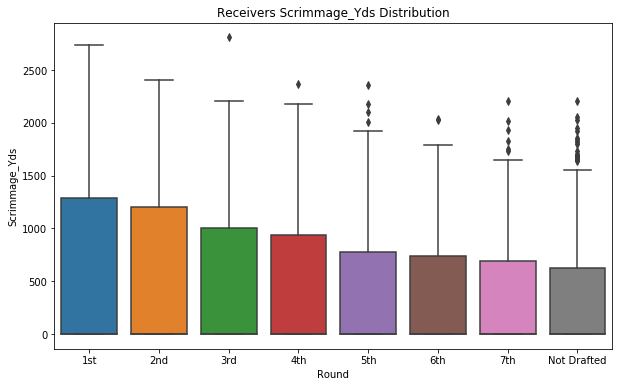

Receivers Scrimmage_Yds_per_Attempt Summary:
count   1812.00
mean       2.05
std        2.92
min        0.00
25%        0.00
50%        0.00
75%        5.20
max       14.80
Name: Scrimmage_Yds_per_Attempt, dtype: float64
----------------------------------------
Receivers Scrimmage_Yds_per_Attempt by Round
             Scrimmage_Yds_per_Attempt
Round                                 
1st                               2.15
2nd                               2.08
3rd                               1.85
4th                               2.31
5th                               1.79
6th                               2.16
7th                               1.91
Not Drafted                       2.08


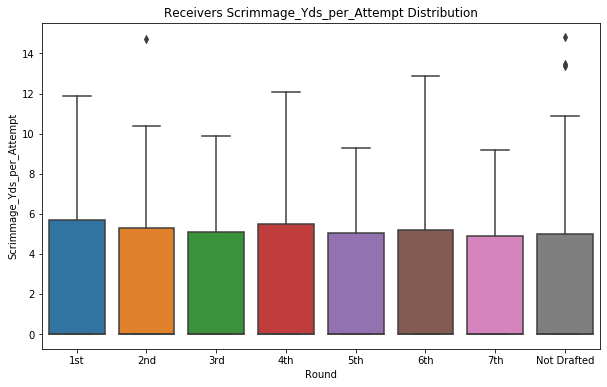

Receivers Scrimmage_TDs Summary:
count   1812.00
mean       3.80
std        6.42
min        0.00
25%        0.00
50%        0.00
75%        7.00
max       32.00
Name: Scrimmage_TDs, dtype: float64
----------------------------------------
Receivers Scrimmage_TDs by Round
             Scrimmage_TDs
Round                     
1st                   5.52
2nd                   5.01
3rd                   4.20
4th                   4.17
5th                   3.57
6th                   3.51
7th                   3.14
Not Drafted           3.10


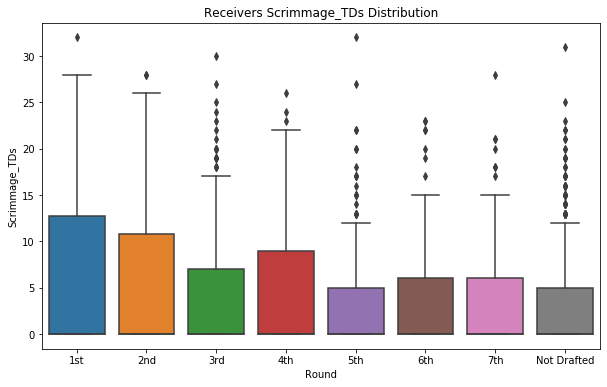

Receivers Rush_AttemptsperGame Summary:
count   1812.00
mean       5.36
std        8.42
min        0.00
25%        0.00
50%        0.00
75%       11.42
max       33.55
Name: Rush_AttemptsperGame, dtype: float64
----------------------------------------
Receivers Rush_AttemptsperGame by Round
             Rush_AttemptsperGame
Round                            
1st                          6.76
2nd                          6.06
3rd                          5.32
4th                          6.11
5th                          5.00
6th                          5.09
7th                          4.62
Not Drafted                  4.96


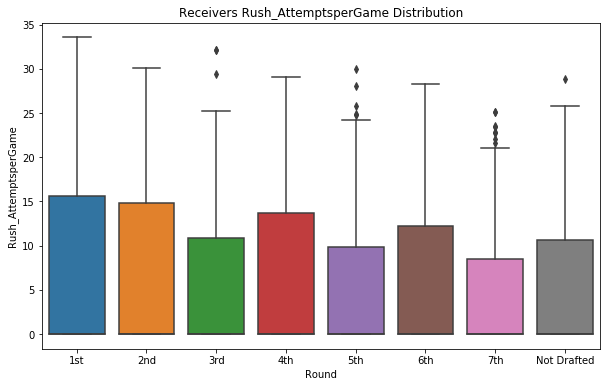

Receivers Rush_YdsperGame Summary:
count   1812.00
mean      28.71
std       46.06
min       -0.31
25%        0.00
50%        0.00
75%       57.80
max      196.18
Name: Rush_YdsperGame, dtype: float64
----------------------------------------
Receivers Rush_YdsperGame by Round
             Rush_YdsperGame
Round                       
1st                    40.40
2nd                    33.76
3rd                    29.68
4th                    33.05
5th                    26.89
6th                    27.19
7th                    24.23
Not Drafted            24.79


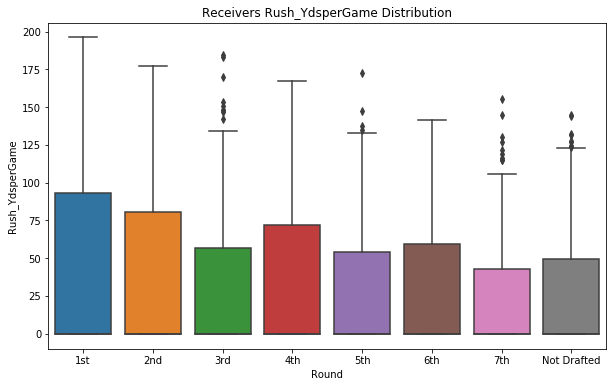

Receivers Rush_TDsperGame Summary:
count   1812.00
mean       0.29
std        0.49
min        0.00
25%        0.00
50%        0.00
75%        0.50
max        3.00
Name: Rush_TDsperGame, dtype: float64
----------------------------------------
Receivers Rush_TDsperGame by Round
             Rush_TDsperGame
Round                       
1st                     0.42
2nd                     0.36
3rd                     0.31
4th                     0.33
5th                     0.27
6th                     0.27
7th                     0.24
Not Drafted             0.25


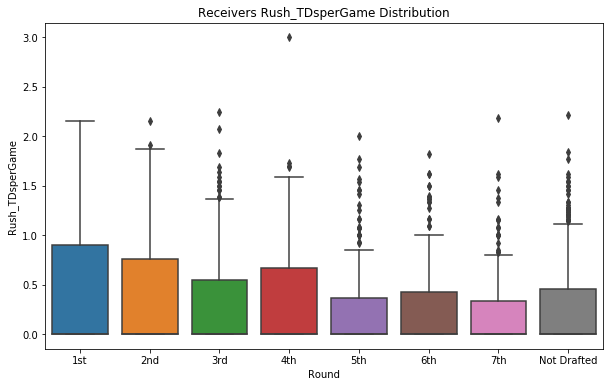

Receivers ReceptionsperGame Summary:
count   1812.00
mean       0.59
std        1.04
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        8.36
Name: ReceptionsperGame, dtype: float64
----------------------------------------
Receivers ReceptionsperGame by Round
             ReceptionsperGame
Round                         
1st                       0.64
2nd                       0.62
3rd                       0.52
4th                       0.66
5th                       0.53
6th                       0.58
7th                       0.56
Not Drafted               0.59


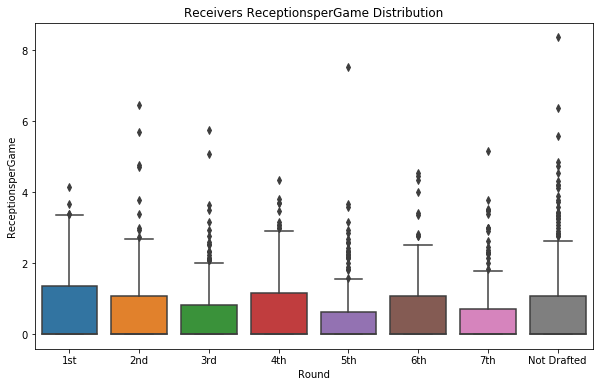

Receivers Rec_YdsperGame Summary:
count   1812.00
mean       5.51
std       10.43
min       -0.50
25%        0.00
50%        0.00
75%        7.90
max       78.83
Name: Rec_YdsperGame, dtype: float64
----------------------------------------
Receivers Rec_YdsperGame by Round
             Rec_YdsperGame
Round                      
1st                    6.48
2nd                    6.39
3rd                    5.41
4th                    5.86
5th                    5.20
6th                    5.18
7th                    5.07
Not Drafted            5.21


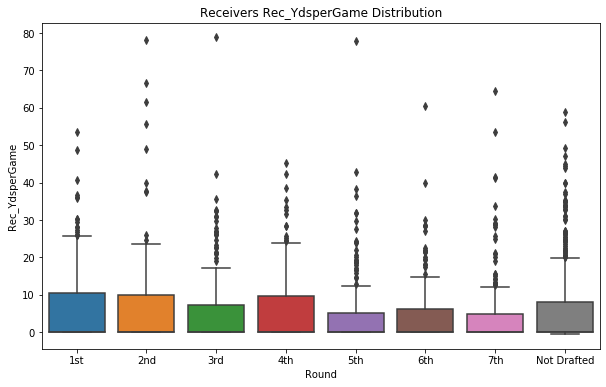

Receivers Rec_TDsperGame Summary:
count   1812.00
mean       0.03
std        0.09
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.79
Name: Rec_TDsperGame, dtype: float64
----------------------------------------
Receivers Rec_TDsperGame by Round
             Rec_TDsperGame
Round                      
1st                    0.04
2nd                    0.04
3rd                    0.03
4th                    0.04
5th                    0.03
6th                    0.03
7th                    0.03
Not Drafted            0.03


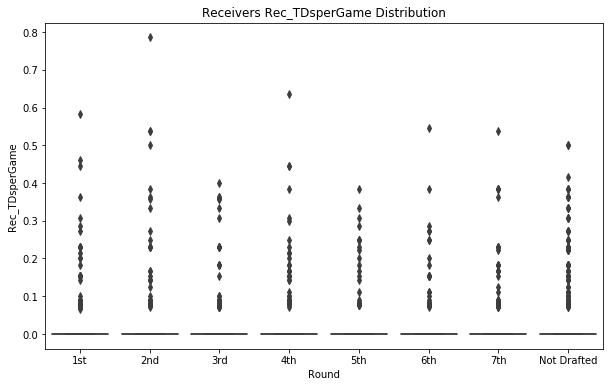

Receivers Plays_from_ScrimmageperGame Summary:
count   1812.00
mean       5.95
std        9.17
min        0.00
25%        0.00
50%        0.00
75%       13.08
max       34.45
Name: Plays_from_ScrimmageperGame, dtype: float64
----------------------------------------
Receivers Plays_from_ScrimmageperGame by Round
             Plays_from_ScrimmageperGame
Round                                   
1st                                 7.41
2nd                                 6.68
3rd                                 5.84
4th                                 6.77
5th                                 5.52
6th                                 5.67
7th                                 5.18
Not Drafted                         5.55


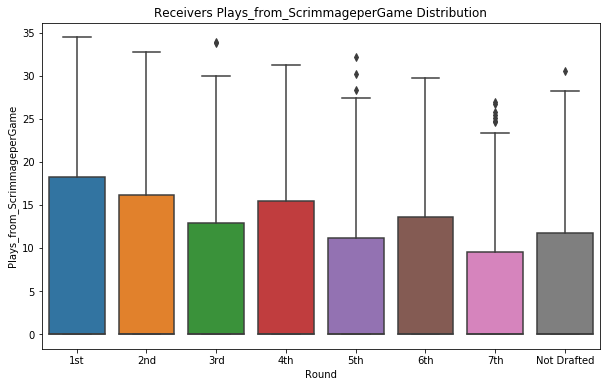

Receivers Scrimmage_YdsperGame Summary:
count   1812.00
mean      34.22
std       53.15
min        0.00
25%        0.00
50%        0.00
75%       69.92
max      200.75
Name: Scrimmage_YdsperGame, dtype: float64
----------------------------------------
Receivers Scrimmage_YdsperGame by Round
             Scrimmage_YdsperGame
Round                            
1st                         46.88
2nd                         40.15
3rd                         35.09
4th                         38.91
5th                         32.09
6th                         32.36
7th                         29.30
Not Drafted                 29.99


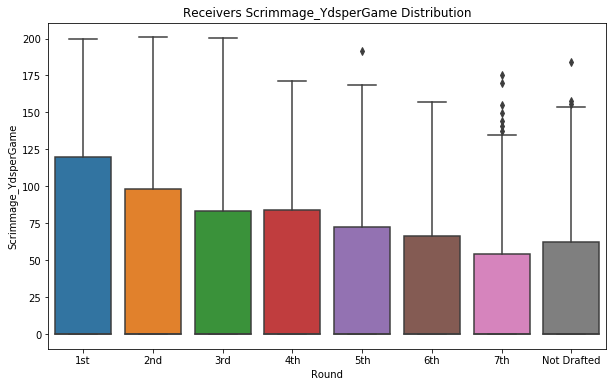

Receivers Scrimmage_TDsperGame Summary:
count   1812.00
mean       0.32
std        0.53
min        0.00
25%        0.00
50%        0.00
75%        0.58
max        3.00
Name: Scrimmage_TDsperGame, dtype: float64
----------------------------------------
Receivers Scrimmage_TDsperGame by Round
             Scrimmage_TDsperGame
Round                            
1st                          0.46
2nd                          0.41
3rd                          0.34
4th                          0.37
5th                          0.30
6th                          0.31
7th                          0.27
Not Drafted                  0.27


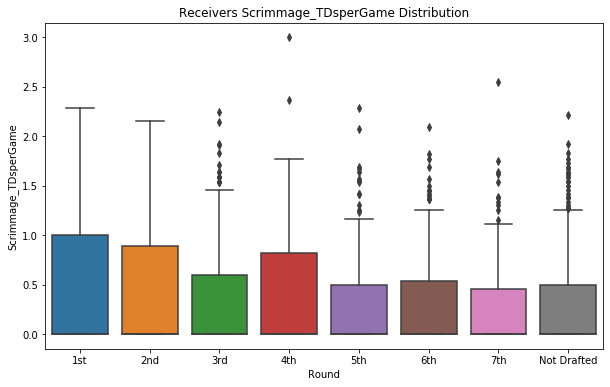

In [26]:
plot_stats('Receivers', receivers_df, rushing_stats)

In [27]:
for i in rushing_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Receivers', receivers_df, i)
    print('')
    print('*' * 40)

Rush_Rec_Games ANOVA Test:
----------------------------------------
              df   sum_sq  mean_sq    F  PR(>F)
Round       7.00    94.17    13.45 0.42    0.89
Residual 1804.00 57945.02    32.12  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.1352    0.9 -1.7675 2.0379  False
   1st         3rd  -0.2536    0.9 -2.1273 1.6201  False
   1st         4th   0.5434    0.9 -1.2983 2.3851  False
   1st         5th  -0.2708    0.9 -2.2275 1.6859  False
   1st         6th   0.2246    0.9   -1.78 2.2291  False
   1st         7th   -0.061    0.9 -1.9994 1.8774  False
   1st Not Drafted   0.1572    0.9 -1.3864 1.7008  False
   2nd         3rd  -0.3888    0.9 -2.2026  1.425  False
   2nd         4th   0.4082    0.9 -1.3726  2.189  False
   2nd         5th   -0.406    0.9 -2.3054 1.4935  False
   2nd         6th   0.0894    0.9 -1.8593 2.0

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd  -0.5028    0.9 -2.4716   1.466  False
   1st         3rd  -1.1622  0.592 -3.1009  0.7766  False
   1st         4th  -1.2128 0.5251 -3.1185  0.6929  False
   1st         5th  -1.7289 0.1598 -3.7535  0.2958  False
   1st         6th  -1.8606 0.1169 -3.9347  0.2136  False
   1st         7th  -2.2535 0.0153 -4.2593 -0.2478   True
   1st Not Drafted   -2.199  0.001 -3.7962 -0.6018   True
   2nd         3rd  -0.6594    0.9 -2.5362  1.2174  False
   2nd         4th  -0.7101    0.9 -2.5527  1.1326  False
   2nd         5th  -1.2261 0.5479 -3.1915  0.7393  False
   2nd         6th  -1.3578 0.4551 -3.3742  0.6586  False
   2nd         7th  -1.7508 0.1145 -3.6967  0.1952  False
   2nd Not Drafted  -1.6963 0.0167 -3.2177 -0.1749   True
   3rd         4th  -0.0506    0.9 -1.8611  1.7599  False
   3rd        

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0052    0.9 -0.3466 0.3362  False
   1st         3rd   -0.153 0.8537 -0.4892 0.1832  False
   1st         4th  -0.1375    0.9  -0.468  0.193  False
   1st         5th  -0.2229  0.528  -0.574 0.1282  False
   1st         6th  -0.1483    0.9  -0.508 0.2114  False
   1st         7th  -0.1231    0.9 -0.4709 0.2247  False
   1st Not Drafted  -0.2205 0.2344 -0.4974 0.0565  False
   2nd         3rd  -0.1478 0.8556 -0.4732 0.1777  False
   2nd         4th  -0.1323    0.9 -0.4518 0.1873  False
   2nd         5th  -0.2176 0.5211 -0.5585 0.1232  False
   2nd         6th  -0.1431    0.9 -0.4927 0.2066  False
   2nd         7th  -0.1179    0.9 -0.4553 0.2196  False
   2nd Not Drafted  -0.2152 0.2065 -0.4791 0.0486  False
   3rd         4th   0.0155    0.9 -0.2985 0.3294  False
   3rd         5th  -0.0699    

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd   -0.508    0.9 -2.6498  1.6338  False
   1st         3rd  -1.3152 0.5484 -3.4243   0.794  False
   1st         4th  -1.3503  0.498 -3.4235  0.7229  False
   1st         5th  -1.9517 0.1261 -4.1543  0.2509  False
   1st         6th  -2.0088 0.1231 -4.2653  0.2476  False
   1st         7th  -2.3766 0.0217 -4.5587 -0.1946   True
   1st Not Drafted  -2.4195  0.001 -4.1571 -0.6819   True
   2nd         3rd  -0.8072    0.9 -2.8489  1.2346  False
   2nd         4th  -0.8423    0.9 -2.8469  1.1623  False
   2nd         5th  -1.4438 0.4515 -3.5819  0.6944  False
   2nd         6th  -1.5009 0.4336 -3.6944  0.6927  False
   2nd         7th  -1.8686 0.1293 -3.9856  0.2483  False
   2nd Not Drafted  -1.9115  0.011 -3.5666 -0.2564   True
   3rd         4th  -0.0351    0.9 -2.0048  1.9345  False
   3rd        

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1    group2   meandiff p-adj  lower  upper  reject
-------------------------------------------------------
   1st         2nd   -0.023   0.9 -0.3735 0.3276  False
   1st         3rd  -0.1231   0.9 -0.4683 0.2221  False
   1st         4th   0.0111   0.9 -0.3282 0.3504  False
   1st         5th  -0.1164   0.9 -0.4769 0.2441  False
   1st         6th   -0.061   0.9 -0.4303 0.3084  False
   1st         7th   -0.087   0.9 -0.4441 0.2702  False
   1st Not Drafted  -0.0537   0.9 -0.3381 0.2307  False
   2nd         3rd  -0.1001   0.9 -0.4343  0.234  False
   2nd         4th   0.0341   0.9  -0.294 0.3621  False
   2nd         5th  -0.0935   0.9 -0.4434 0.2565  False
   2nd         6th   -0.038   0.9  -0.397  0.321  False
   2nd         7th   -0.064   0.9 -0.4105 0.2825  False
   2nd Not Drafted  -0.0308   0.9 -0.3016 0.2401  False
   3rd         4th   0.1342   0.9 -0.1882 0.4566  False
   3rd         5th   0.0067   0.9 -0.3379 0.3513

              df  sum_sq  mean_sq    F  PR(>F)
Round       7.00    6.62     0.95 3.35    0.00
Residual 1804.00  508.73     0.28  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd  -0.0561    0.9 -0.2344  0.1222  False
   1st         3rd  -0.1223  0.409 -0.2978  0.0533  False
   1st         4th  -0.0941 0.6905 -0.2666  0.0785  False
   1st         5th  -0.1653 0.1129 -0.3486   0.018  False
   1st         6th  -0.1532  0.207  -0.341  0.0347  False
   1st         7th   -0.188 0.0364 -0.3697 -0.0064   True
   1st Not Drafted  -0.1869 0.0023 -0.3316 -0.0423   True
   2nd         3rd  -0.0662    0.9 -0.2361  0.1038  False
   2nd         4th   -0.038    0.9 -0.2048  0.1289  False
   2nd         5th  -0.1092 0.5664 -0.2872  0.0688  False
   2nd         6th  -0.0971 0.7148 -0.2797  0.0855  False
   2nd         7th  -0.1319 0.3098 -0.3081  0.

### College Stats - Defense

In [28]:
defense_stats = ['Defense_Games', 'Solo_Tackles', 'Assisted_Tackles', 'Ttl_Tackles', 'Loss', 'Sacks', 
                 'Defensive_Interceptions', 'Def_Int_Yds', 'Yds_per_Int', 'Pick_6', 'Defended_Passes', 
                 'Recovered_Fumbles', 'Rec_Fumbles_Yds', 'Fumbles_Returned_TD', 'Forced_Fumbles', 
                 'Solo_TacklesperGame', 'Assisted_TacklesperGame', 'Ttl_TacklesperGame', 'LossperGame', 
                 'SacksperGame', 'Defensive_InterceptionsperGame', 'Def_Int_YdsperGame', 'Pick_6perGame', 
                 'Defended_PassesperGame', 'Recovered_FumblesperGame', 'Rec_Fumbles_YdsperGame', 
                 'Fumbles_Returned_TDperGame', 'Forced_FumblesperGame']

In [30]:
receivers_df[defense_stats].describe()

,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Solo_TacklesperGame,Assisted_TacklesperGame,Ttl_TacklesperGame,LossperGame,SacksperGame,Defensive_InterceptionsperGame,Def_Int_YdsperGame,Pick_6perGame,Defended_PassesperGame,Recovered_FumblesperGame,Rec_Fumbles_YdsperGame,Fumbles_Returned_TDperGame,Forced_FumblesperGame
count,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00
mean,7.62,0.80,0.30,1.10,0.03,0.01,0.01,0.08,0.07,0.00,0.01,0.01,0.01,0.01,0.01,0.07,0.02,0.09,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
std,5.93,3.09,2.78,5.76,0.48,0.23,0.09,1.97,1.80,0.03,0.12,0.10,0.47,0.09,0.10,0.25,0.22,0.46,0.04,0.02,0.01,0.18,0.00,0.01,0.01,0.05,0.01,0.01
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,11.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,13.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,15.00,78.00,81.00,159.00,13.00,5.50,2.00,68.00,68.00,1.00,4.00,2.00,20.00,1.00,2.00,6.50,6.75,13.25,1.00,0.42,0.17,6.18,0.09,0.31,0.17,2.00,0.10,0.15


Receivers Defense_Games Summary:
count   1812.00
mean       7.62
std        5.93
min        0.00
25%        0.00
50%       11.00
75%       13.00
max       15.00
Name: Defense_Games, dtype: float64
----------------------------------------
Receivers Defense_Games by Round
             Defense_Games
Round                     
1st                   6.87
2nd                   8.21
3rd                   8.37
4th                   7.33
5th                   8.55
6th                   8.32
7th                   7.40
Not Drafted           7.20


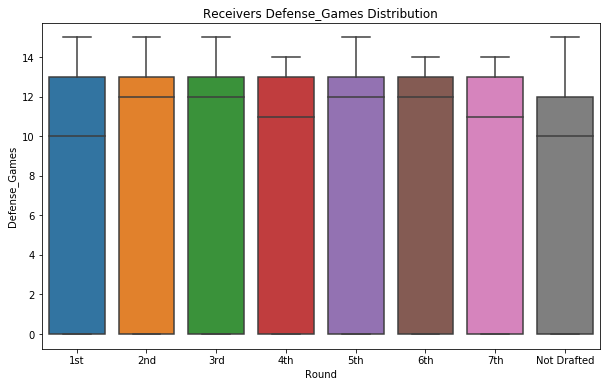

Receivers Solo_Tackles Summary:
count   1812.00
mean       0.80
std        3.09
min        0.00
25%        0.00
50%        0.00
75%        1.00
max       78.00
Name: Solo_Tackles, dtype: float64
----------------------------------------
Receivers Solo_Tackles by Round
             Solo_Tackles
Round                    
1st                  0.47
2nd                  0.75
3rd                  1.26
4th                  0.74
5th                  0.86
6th                  0.91
7th                  0.58
Not Drafted          0.79


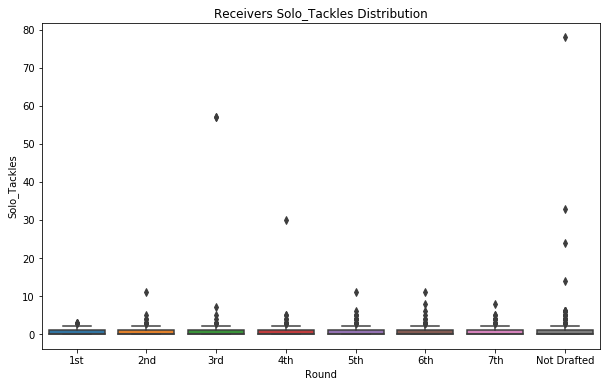

Receivers Assisted_Tackles Summary:
count   1812.00
mean       0.30
std        2.78
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       81.00
Name: Assisted_Tackles, dtype: float64
----------------------------------------
Receivers Assisted_Tackles by Round
             Assisted_Tackles
Round                        
1st                      0.12
2nd                      0.16
3rd                      0.70
4th                      0.23
5th                      0.25
6th                      0.16
7th                      0.17
Not Drafted              0.36


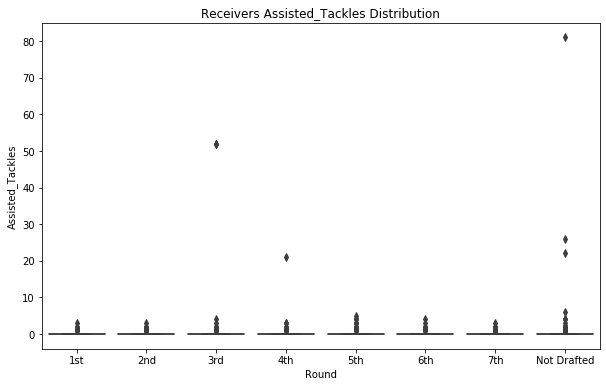

Receivers Ttl_Tackles Summary:
count   1812.00
mean       1.10
std        5.76
min        0.00
25%        0.00
50%        0.00
75%        1.00
max      159.00
Name: Ttl_Tackles, dtype: float64
----------------------------------------
Receivers Ttl_Tackles by Round
             Ttl_Tackles
Round                   
1st                 0.58
2nd                 0.91
3rd                 1.96
4th                 0.98
5th                 1.12
6th                 1.07
7th                 0.76
Not Drafted         1.15


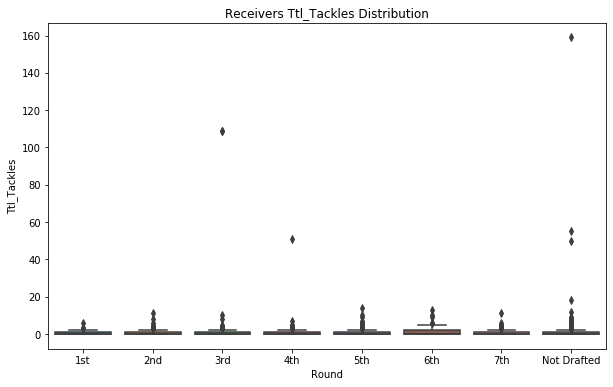

Receivers Loss Summary:
count   1812.00
mean       0.03
std        0.48
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       13.00
Name: Loss, dtype: float64
----------------------------------------
Receivers Loss by Round
             Loss
Round            
1st          0.00
2nd          0.01
3rd          0.09
4th          0.03
5th          0.03
6th          0.00
7th          0.00
Not Drafted  0.05


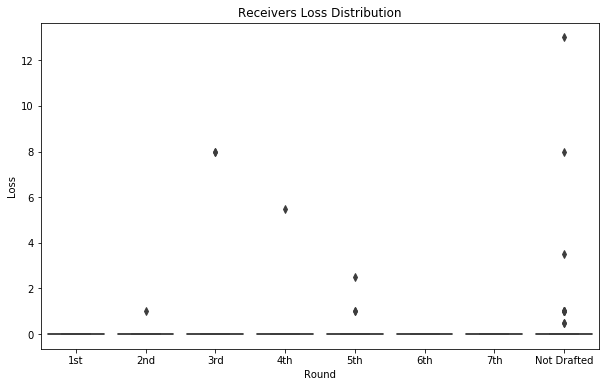

Receivers Sacks Summary:
count   1812.00
mean       0.01
std        0.23
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        5.50
Name: Sacks, dtype: float64
----------------------------------------
Receivers Sacks by Round
             Sacks
Round             
1st           0.00
2nd           0.01
3rd           0.05
4th           0.01
5th           0.02
6th           0.00
7th           0.00
Not Drafted   0.01


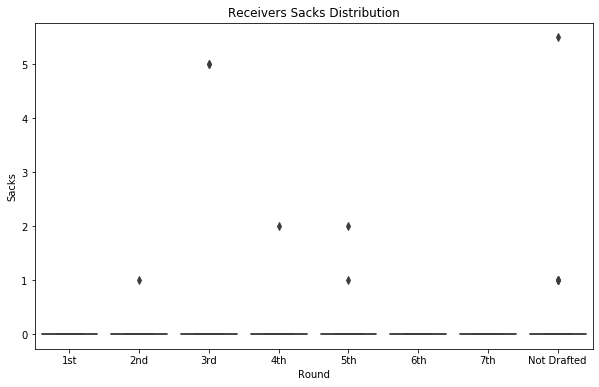

Receivers Defensive_Interceptions Summary:
count   1812.00
mean       0.01
std        0.09
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        2.00
Name: Defensive_Interceptions, dtype: float64
----------------------------------------
Receivers Defensive_Interceptions by Round
             Defensive_Interceptions
Round                               
1st                             0.00
2nd                             0.01
3rd                             0.01
4th                             0.01
5th                             0.00
6th                             0.00
7th                             0.00
Not Drafted                     0.01


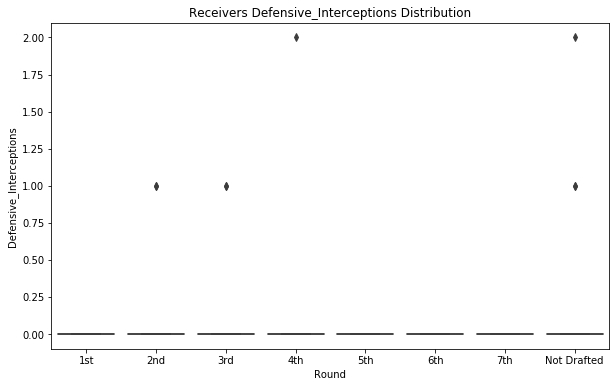

Receivers Def_Int_Yds Summary:
count   1812.00
mean       0.08
std        1.97
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       68.00
Name: Def_Int_Yds, dtype: float64
----------------------------------------
Receivers Def_Int_Yds by Round
             Def_Int_Yds
Round                   
1st                 0.00
2nd                 0.56
3rd                 0.00
4th                 0.19
5th                 0.00
6th                 0.00
7th                 0.00
Not Drafted         0.01


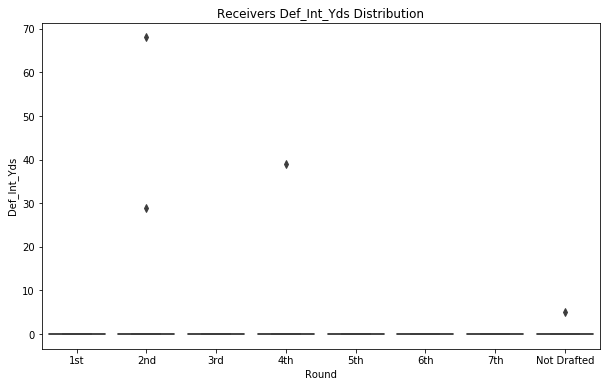

Receivers Yds_per_Int Summary:
count   1812.00
mean       0.07
std        1.80
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       68.00
Name: Yds_per_Int, dtype: float64
----------------------------------------
Receivers Yds_per_Int by Round
             Yds_per_Int
Round                   
1st                 0.00
2nd                 0.56
3rd                 0.00
4th                 0.10
5th                 0.00
6th                 0.00
7th                 0.00
Not Drafted         0.01


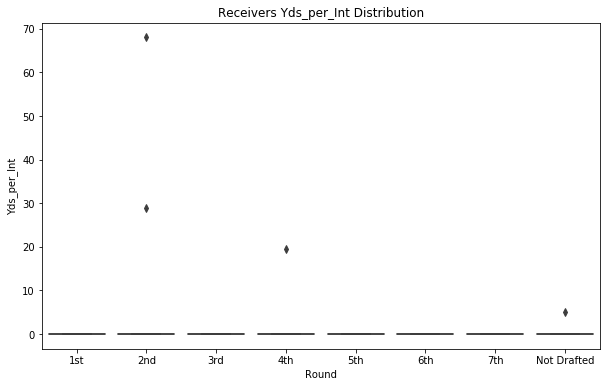

Receivers Pick_6 Summary:
count   1812.00
mean       0.00
std        0.03
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: Pick_6, dtype: float64
----------------------------------------
Receivers Pick_6 by Round
             Pick_6
Round              
1st            0.00
2nd            0.01
3rd            0.00
4th            0.00
5th            0.00
6th            0.00
7th            0.00
Not Drafted    0.00


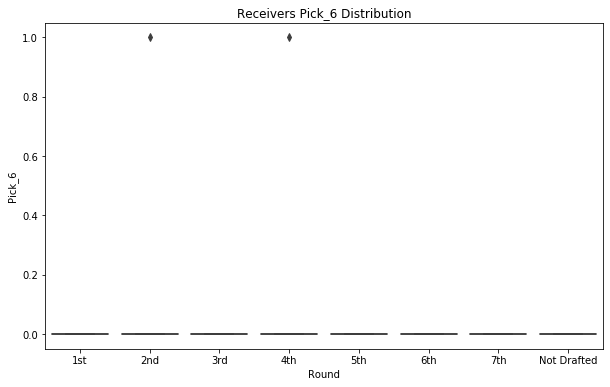

Receivers Defended_Passes Summary:
count   1812.00
mean       0.01
std        0.12
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        4.00
Name: Defended_Passes, dtype: float64
----------------------------------------
Receivers Defended_Passes by Round
             Defended_Passes
Round                       
1st                     0.01
2nd                     0.01
3rd                     0.01
4th                     0.00
5th                     0.03
6th                     0.00
7th                     0.01
Not Drafted             0.01


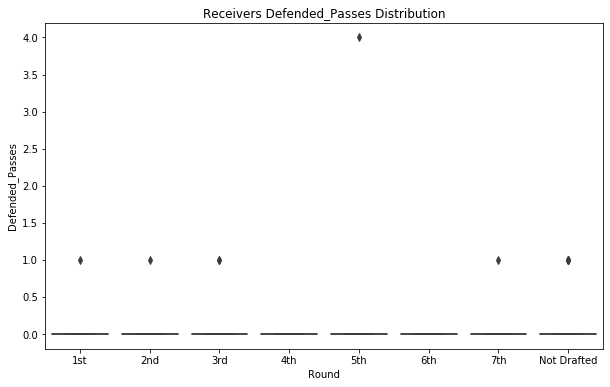

Receivers Recovered_Fumbles Summary:
count   1812.00
mean       0.01
std        0.10
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        2.00
Name: Recovered_Fumbles, dtype: float64
----------------------------------------
Receivers Recovered_Fumbles by Round
             Recovered_Fumbles
Round                         
1st                       0.00
2nd                       0.04
3rd                       0.01
4th                       0.00
5th                       0.01
6th                       0.01
7th                       0.01
Not Drafted               0.00


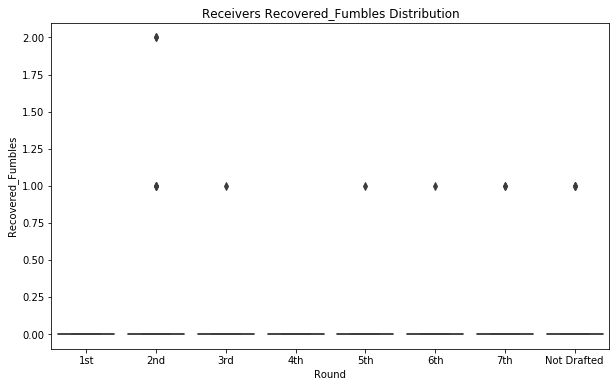

Receivers Rec_Fumbles_Yds Summary:
count   1812.00
mean       0.01
std        0.47
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       20.00
Name: Rec_Fumbles_Yds, dtype: float64
----------------------------------------
Receivers Rec_Fumbles_Yds by Round
             Rec_Fumbles_Yds
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.03


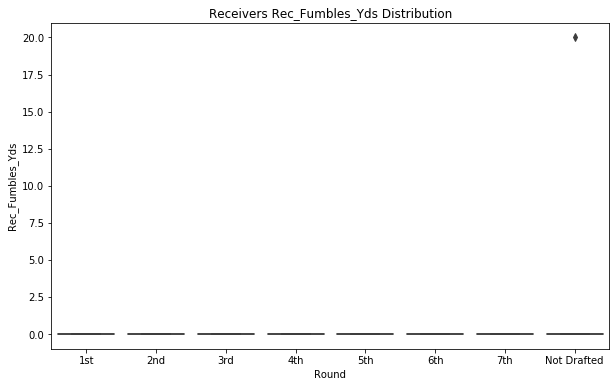

Receivers Fumbles_Returned_TD Summary:
count   1812.00
mean       0.01
std        0.09
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: Fumbles_Returned_TD, dtype: float64
----------------------------------------
Receivers Fumbles_Returned_TD by Round
             Fumbles_Returned_TD
Round                           
1st                         0.01
2nd                         0.01
3rd                         0.01
4th                         0.01
5th                         0.01
6th                         0.01
7th                         0.00
Not Drafted                 0.00


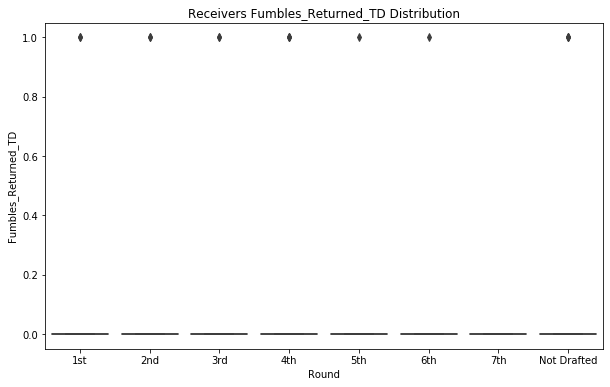

Receivers Forced_Fumbles Summary:
count   1812.00
mean       0.01
std        0.10
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        2.00
Name: Forced_Fumbles, dtype: float64
----------------------------------------
Receivers Forced_Fumbles by Round
             Forced_Fumbles
Round                      
1st                    0.02
2nd                    0.00
3rd                    0.00
4th                    0.01
5th                    0.01
6th                    0.01
7th                    0.01
Not Drafted            0.01


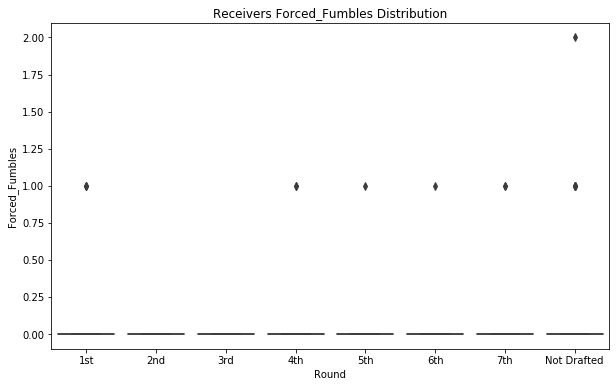

Receivers Solo_TacklesperGame Summary:
count   1812.00
mean       0.07
std        0.25
min        0.00
25%        0.00
50%        0.00
75%        0.08
max        6.50
Name: Solo_TacklesperGame, dtype: float64
----------------------------------------
Receivers Solo_TacklesperGame by Round
             Solo_TacklesperGame
Round                           
1st                         0.04
2nd                         0.06
3rd                         0.10
4th                         0.06
5th                         0.07
6th                         0.08
7th                         0.05
Not Drafted                 0.07


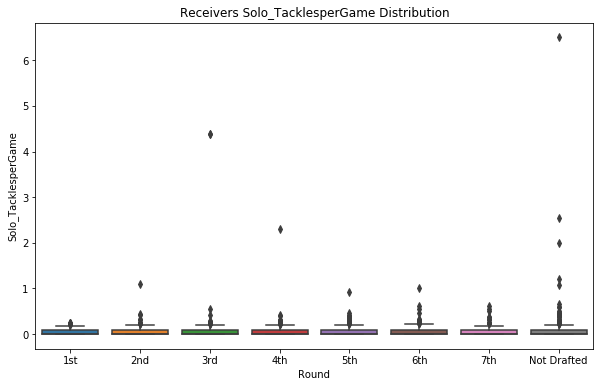

Receivers Assisted_TacklesperGame Summary:
count   1812.00
mean       0.02
std        0.22
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        6.75
Name: Assisted_TacklesperGame, dtype: float64
----------------------------------------
Receivers Assisted_TacklesperGame by Round
             Assisted_TacklesperGame
Round                               
1st                             0.01
2nd                             0.01
3rd                             0.05
4th                             0.02
5th                             0.02
6th                             0.01
7th                             0.01
Not Drafted                     0.03


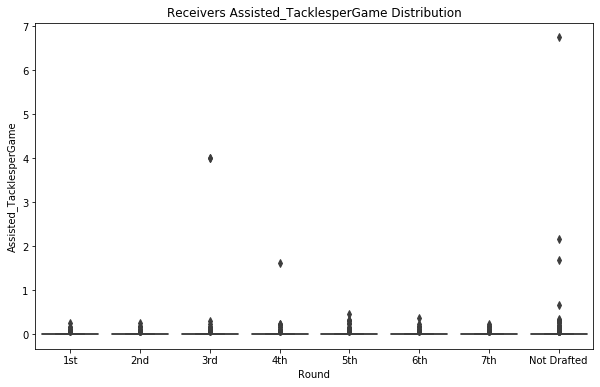

Receivers Ttl_TacklesperGame Summary:
count   1812.00
mean       0.09
std        0.46
min        0.00
25%        0.00
50%        0.00
75%        0.08
max       13.25
Name: Ttl_TacklesperGame, dtype: float64
----------------------------------------
Receivers Ttl_TacklesperGame by Round
             Ttl_TacklesperGame
Round                          
1st                        0.05
2nd                        0.08
3rd                        0.15
4th                        0.08
5th                        0.09
6th                        0.09
7th                        0.06
Not Drafted                0.10


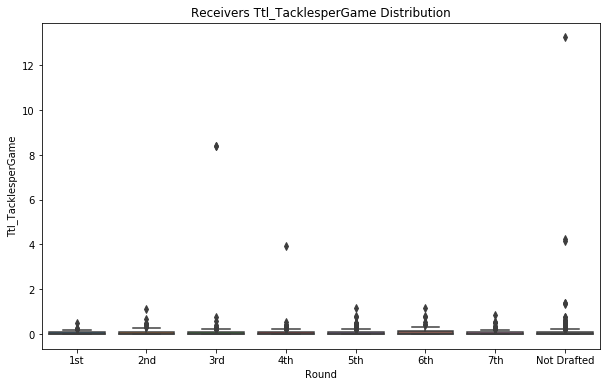

Receivers LossperGame Summary:
count   1812.00
mean       0.00
std        0.04
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: LossperGame, dtype: float64
----------------------------------------
Receivers LossperGame by Round
             LossperGame
Round                   
1st                 0.00
2nd                 0.00
3rd                 0.01
4th                 0.00
5th                 0.00
6th                 0.00
7th                 0.00
Not Drafted         0.00


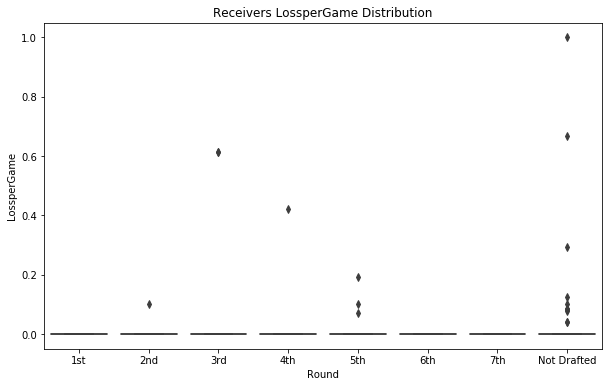

Receivers SacksperGame Summary:
count   1812.00
mean       0.00
std        0.02
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.42
Name: SacksperGame, dtype: float64
----------------------------------------
Receivers SacksperGame by Round
             SacksperGame
Round                    
1st                  0.00
2nd                  0.00
3rd                  0.00
4th                  0.00
5th                  0.00
6th                  0.00
7th                  0.00
Not Drafted          0.00


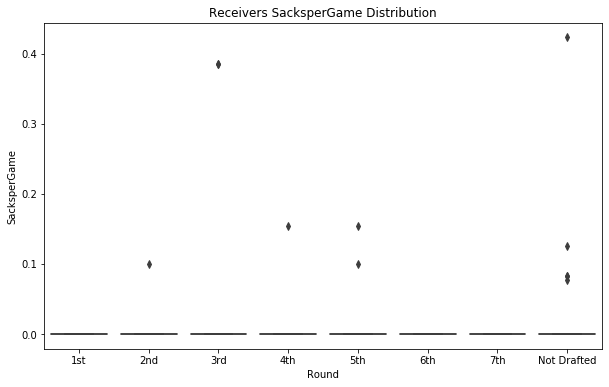

Receivers Defensive_InterceptionsperGame Summary:
count   1812.00
mean       0.00
std        0.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.17
Name: Defensive_InterceptionsperGame, dtype: float64
----------------------------------------
Receivers Defensive_InterceptionsperGame by Round
             Defensive_InterceptionsperGame
Round                                      
1st                                    0.00
2nd                                    0.00
3rd                                    0.00
4th                                    0.00
5th                                    0.00
6th                                    0.00
7th                                    0.00
Not Drafted                            0.00


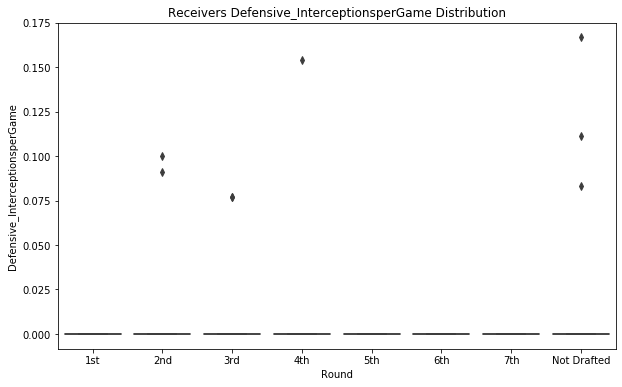

Receivers Def_Int_YdsperGame Summary:
count   1812.00
mean       0.01
std        0.18
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        6.18
Name: Def_Int_YdsperGame, dtype: float64
----------------------------------------
Receivers Def_Int_YdsperGame by Round
             Def_Int_YdsperGame
Round                          
1st                        0.00
2nd                        0.05
3rd                        0.00
4th                        0.01
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


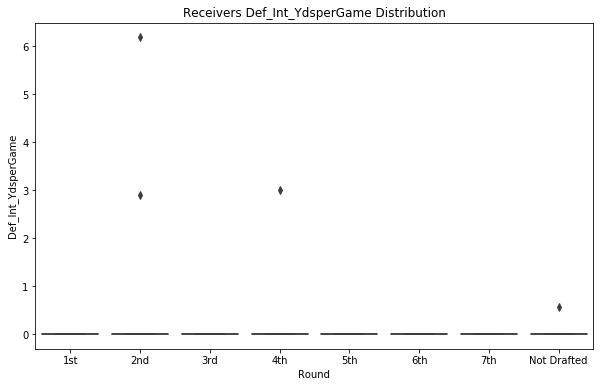

Receivers Pick_6perGame Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.09
Name: Pick_6perGame, dtype: float64
----------------------------------------
Receivers Pick_6perGame by Round
             Pick_6perGame
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


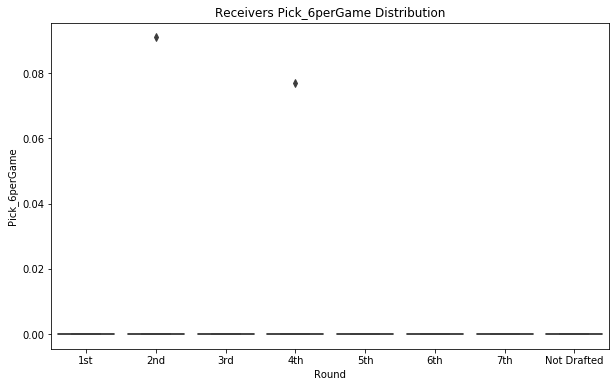

Receivers Defended_PassesperGame Summary:
count   1812.00
mean       0.00
std        0.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.31
Name: Defended_PassesperGame, dtype: float64
----------------------------------------
Receivers Defended_PassesperGame by Round
             Defended_PassesperGame
Round                              
1st                            0.00
2nd                            0.00
3rd                            0.00
4th                            0.00
5th                            0.00
6th                            0.00
7th                            0.00
Not Drafted                    0.00


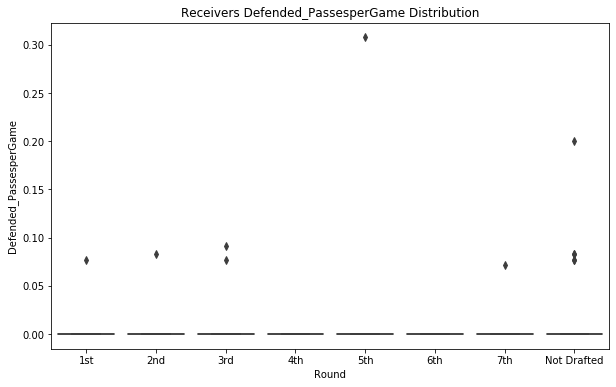

Receivers Recovered_FumblesperGame Summary:
count   1812.00
mean       0.00
std        0.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.17
Name: Recovered_FumblesperGame, dtype: float64
----------------------------------------
Receivers Recovered_FumblesperGame by Round
             Recovered_FumblesperGame
Round                                
1st                              0.00
2nd                              0.00
3rd                              0.00
4th                              0.00
5th                              0.00
6th                              0.00
7th                              0.00
Not Drafted                      0.00


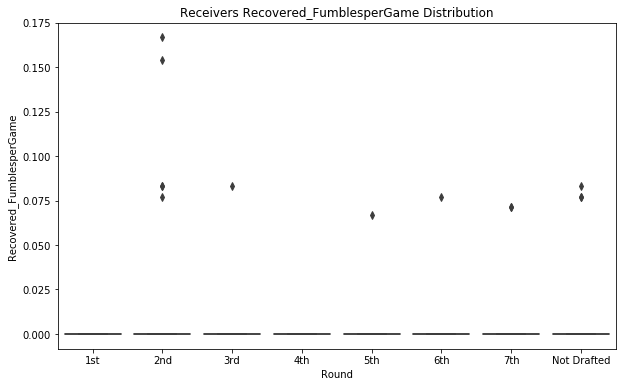

Receivers Rec_Fumbles_YdsperGame Summary:
count   1812.00
mean       0.00
std        0.05
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        2.00
Name: Rec_Fumbles_YdsperGame, dtype: float64
----------------------------------------
Receivers Rec_Fumbles_YdsperGame by Round
             Rec_Fumbles_YdsperGame
Round                              
1st                            0.00
2nd                            0.00
3rd                            0.00
4th                            0.00
5th                            0.00
6th                            0.00
7th                            0.00
Not Drafted                    0.00


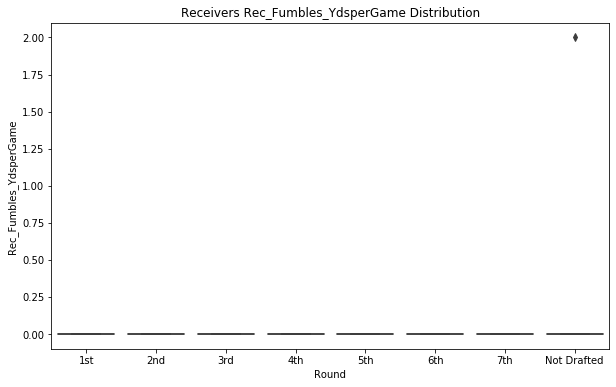

Receivers Fumbles_Returned_TDperGame Summary:
count   1812.00
mean       0.00
std        0.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.10
Name: Fumbles_Returned_TDperGame, dtype: float64
----------------------------------------
Receivers Fumbles_Returned_TDperGame by Round
             Fumbles_Returned_TDperGame
Round                                  
1st                                0.00
2nd                                0.00
3rd                                0.00
4th                                0.00
5th                                0.00
6th                                0.00
7th                                0.00
Not Drafted                        0.00


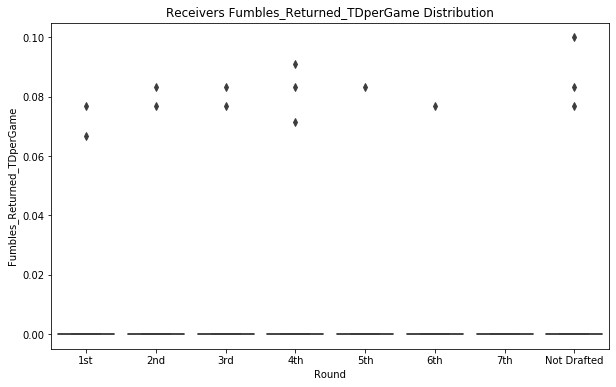

Receivers Forced_FumblesperGame Summary:
count   1812.00
mean       0.00
std        0.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.15
Name: Forced_FumblesperGame, dtype: float64
----------------------------------------
Receivers Forced_FumblesperGame by Round
             Forced_FumblesperGame
Round                             
1st                           0.00
2nd                           0.00
3rd                           0.00
4th                           0.00
5th                           0.00
6th                           0.00
7th                           0.00
Not Drafted                   0.00


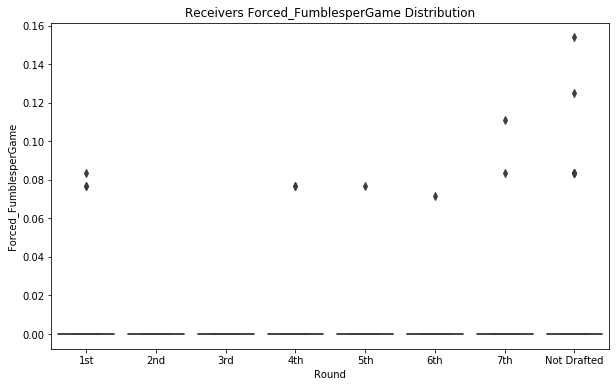

In [34]:
plot_stats('Receivers', receivers_df, defense_stats)

In [33]:
for i in defense_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Receivers', receivers_df, i)
    print('')
    print('*' * 40)

Defense_Games ANOVA Test:
----------------------------------------
              df   sum_sq  mean_sq    F  PR(>F)
Round       7.00   589.88    84.27 2.41    0.02
Residual 1804.00 62995.18    34.92  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   1.3425 0.4485 -0.6414 3.3264  False
   1st         3rd   1.4955 0.2817 -0.4581 3.4491  False
   1st         4th   0.4582    0.9 -1.4621 2.3785  False
   1st         5th   1.6783 0.1974 -0.3619 3.7184  False
   1st         6th    1.449 0.4153  -0.641 3.5391  False
   1st         7th   0.5274    0.9 -1.4937 2.5485  False
   1st Not Drafted    0.333    0.9 -1.2764 1.9424  False
   2nd         3rd   0.1529    0.9 -1.7382 2.0441  False
   2nd         4th  -0.8843 0.8153  -2.741 0.9725  False
   2nd         5th   0.3357    0.9 -1.6447 2.3162  False
   2nd         6th   0.1065    0.9 -1.9253 2.13

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.0057    0.9 -0.1555  0.167  False
   1st         3rd    0.086 0.6965 -0.0727 0.2448  False
   1st         4th   0.0274    0.9 -0.1287 0.1834  False
   1st         5th    0.029    0.9 -0.1368 0.1948  False
   1st         6th      0.0    0.9 -0.1699 0.1699  False
   1st         7th      0.0    0.9 -0.1643 0.1643  False
   1st Not Drafted   0.0492    0.9 -0.0816   0.18  False
   2nd         3rd   0.0803 0.7318 -0.0734  0.234  False
   2nd         4th   0.0216    0.9 -0.1293 0.1725  False
   2nd         5th   0.0233    0.9 -0.1377 0.1842  False
   2nd         6th  -0.0057    0.9 -0.1709 0.1594  False
   2nd         7th  -0.0057    0.9 -0.1651 0.1536  False
   2nd Not Drafted   0.0435    0.9 -0.0811 0.1681  False
   3rd         4th  -0.0587    0.9 -0.2069 0.0896  False
   3rd         5th   -0.057    

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.0057 0.7441 -0.0054 0.0169  False
   1st         3rd      0.0    0.9  -0.011  0.011  False
   1st         4th    0.005 0.8428 -0.0058 0.0158  False
   1st         5th      0.0    0.9 -0.0115 0.0115  False
   1st         6th      0.0    0.9 -0.0117 0.0117  False
   1st         7th      0.0    0.9 -0.0114 0.0114  False
   1st Not Drafted      0.0    0.9  -0.009  0.009  False
   2nd         3rd  -0.0057 0.6983 -0.0164 0.0049  False
   2nd         4th  -0.0008    0.9 -0.0112 0.0097  False
   2nd         5th  -0.0057 0.7425 -0.0169 0.0054  False
   2nd         6th  -0.0057 0.7662 -0.0172 0.0057  False
   2nd         7th  -0.0057 0.7332 -0.0168 0.0053  False
   2nd Not Drafted  -0.0057 0.4675 -0.0144 0.0029  False
   3rd         4th    0.005 0.7989 -0.0053 0.0152  False
   3rd         5th      0.0    

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0195 0.6478 -0.0537 0.0148  False
   1st         3rd  -0.0195 0.6319 -0.0532 0.0143  False
   1st         4th  -0.0095    0.9 -0.0427 0.0236  False
   1st         5th   -0.013    0.9 -0.0483 0.0222  False
   1st         6th  -0.0124    0.9 -0.0485 0.0237  False
   1st         7th  -0.0071    0.9  -0.042 0.0278  False
   1st Not Drafted   -0.007    0.9 -0.0348 0.0208  False
   2nd         3rd      0.0    0.9 -0.0327 0.0327  False
   2nd         4th     0.01    0.9 -0.0221  0.042  False
   2nd         5th   0.0065    0.9 -0.0277 0.0406  False
   2nd         6th   0.0071    0.9  -0.028 0.0422  False
   2nd         7th   0.0124    0.9 -0.0214 0.0463  False
   2nd Not Drafted   0.0125 0.8226  -0.014  0.039  False
   3rd         4th     0.01    0.9 -0.0216 0.0415  False
   3rd         5th   0.0065    

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.0006    0.9 -0.0121 0.0132  False
   1st         3rd   0.0066 0.7161 -0.0058 0.0191  False
   1st         4th   0.0021    0.9 -0.0101 0.0144  False
   1st         5th   0.0023    0.9 -0.0107 0.0154  False
   1st         6th      0.0    0.9 -0.0133 0.0133  False
   1st         7th      0.0    0.9 -0.0129 0.0129  False
   1st Not Drafted   0.0041    0.9 -0.0062 0.0143  False
   2nd         3rd    0.006 0.7707  -0.006 0.0181  False
   2nd         4th   0.0015    0.9 -0.0103 0.0134  False
   2nd         5th   0.0018    0.9 -0.0109 0.0144  False
   2nd         6th  -0.0006    0.9 -0.0135 0.0124  False
   2nd         7th  -0.0006    0.9 -0.0131 0.0119  False
   2nd Not Drafted   0.0035    0.9 -0.0063 0.0133  False
   3rd         4th  -0.0045    0.9 -0.0161 0.0071  False
   3rd         5th  -0.0043    

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.0005 0.6698 -0.0004 0.0015  False
   1st         3rd      0.0    0.9 -0.0009 0.0009  False
   1st         4th   0.0004    0.9 -0.0005 0.0013  False
   1st         5th      0.0    0.9  -0.001  0.001  False
   1st         6th      0.0    0.9  -0.001  0.001  False
   1st         7th      0.0    0.9  -0.001  0.001  False
   1st Not Drafted      0.0    0.9 -0.0008 0.0008  False
   2nd         3rd  -0.0005 0.6203 -0.0014 0.0004  False
   2nd         4th  -0.0001    0.9  -0.001 0.0007  False
   2nd         5th  -0.0005  0.668 -0.0015 0.0004  False
   2nd         6th  -0.0005 0.6935 -0.0015 0.0004  False
   2nd         7th  -0.0005 0.6579 -0.0015 0.0004  False
   2nd Not Drafted  -0.0005  0.362 -0.0012 0.0002  False
   3rd         4th   0.0004 0.8749 -0.0005 0.0012  False
   3rd         5th      0.0    

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0015 0.7115 -0.0044 0.0013  False
   1st         3rd  -0.0015 0.6966 -0.0044 0.0013  False
   1st         4th  -0.0008    0.9 -0.0036  0.002  False
   1st         5th   -0.001    0.9  -0.004 0.0019  False
   1st         6th   -0.001    0.9 -0.0041  0.002  False
   1st         7th  -0.0003    0.9 -0.0033 0.0026  False
   1st Not Drafted  -0.0005    0.9 -0.0028 0.0019  False
   2nd         3rd      0.0    0.9 -0.0028 0.0028  False
   2nd         4th   0.0008    0.9 -0.0019 0.0035  False
   2nd         5th   0.0005    0.9 -0.0024 0.0034  False
   2nd         6th   0.0005    0.9 -0.0025 0.0035  False
   2nd         7th   0.0012    0.9 -0.0016 0.0041  False
   2nd Not Drafted   0.0011 0.7955 -0.0011 0.0033  False
   3rd         4th   0.0008    0.9 -0.0019 0.0034  False
   3rd         5th   0.0005    

### College Stats - Kicking

In [35]:
kicking_stats = ['Kicking_Games', 'XP_Made', 'XP_Attempts', 'XP_Percent', 'FG_Made', 'FG_Attempts', 'FG_Percent', 
                 'TTL_Kicking_Points', 'NumPunts', 'Punt_Yds', 'Yds_per_Punt', 'XP_MadeperGame', 'XP_AttemptsperGame',
                 'FG_MadeperGame', 'FG_AttemptsperGame', 'TTL_Kicking_PointsperGame', 'NumPuntsperGame', 
                 'Punt_YdsperGame']

In [36]:
receivers_df[kicking_stats].describe()

,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame
count,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00
mean,0.01,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,0.45,0.02,0.02,2.35,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,14.00,1.00,1.00,100.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.07,0.07,0.00,0.00,0.07,0.00,0.00


Receivers Kicking_Games Summary:
count   1812.00
mean       0.01
std        0.45
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       14.00
Name: Kicking_Games, dtype: float64
----------------------------------------
Receivers Kicking_Games by Round
             Kicking_Games
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.09
6th                   0.00
7th                   0.00
Not Drafted           0.02


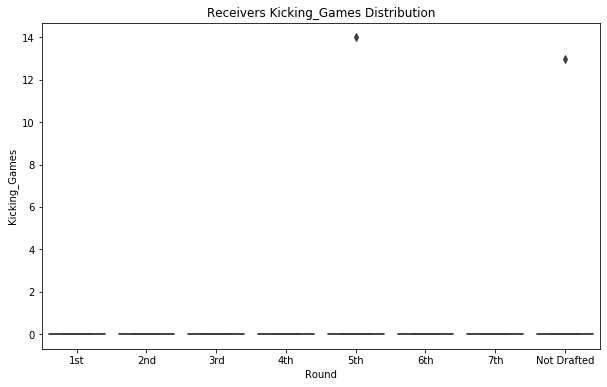

Receivers XP_Made Summary:
count   1812.00
mean       0.00
std        0.02
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: XP_Made, dtype: float64
----------------------------------------
Receivers XP_Made by Round
             XP_Made
Round               
1st             0.00
2nd             0.00
3rd             0.00
4th             0.00
5th             0.01
6th             0.00
7th             0.00
Not Drafted     0.00


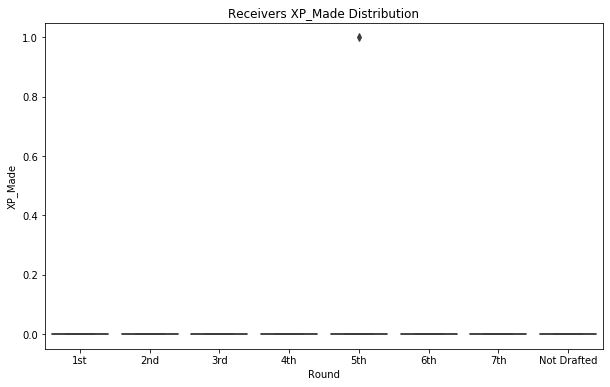

Receivers XP_Attempts Summary:
count   1812.00
mean       0.00
std        0.02
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: XP_Attempts, dtype: float64
----------------------------------------
Receivers XP_Attempts by Round
             XP_Attempts
Round                   
1st                 0.00
2nd                 0.00
3rd                 0.00
4th                 0.00
5th                 0.01
6th                 0.00
7th                 0.00
Not Drafted         0.00


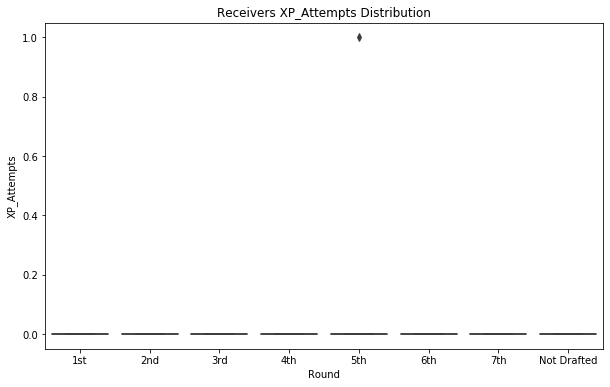

Receivers XP_Percent Summary:
count   1812.00
mean       0.06
std        2.35
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      100.00
Name: XP_Percent, dtype: float64
----------------------------------------
Receivers XP_Percent by Round
             XP_Percent
Round                  
1st                0.00
2nd                0.00
3rd                0.00
4th                0.00
5th                0.65
6th                0.00
7th                0.00
Not Drafted        0.00


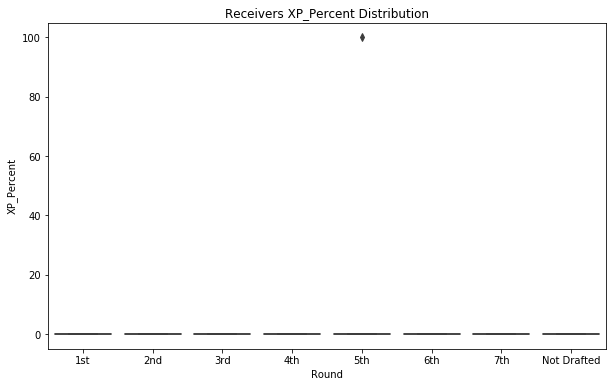

Receivers FG_Made Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: FG_Made, dtype: float64
----------------------------------------
Receivers FG_Made by Round
             FG_Made
Round               
1st             0.00
2nd             0.00
3rd             0.00
4th             0.00
5th             0.00
6th             0.00
7th             0.00
Not Drafted     0.00


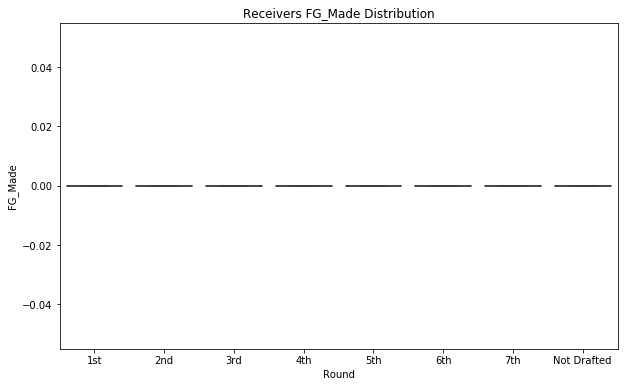

Receivers FG_Attempts Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: FG_Attempts, dtype: float64
----------------------------------------
Receivers FG_Attempts by Round
             FG_Attempts
Round                   
1st                 0.00
2nd                 0.00
3rd                 0.00
4th                 0.00
5th                 0.00
6th                 0.00
7th                 0.00
Not Drafted         0.00


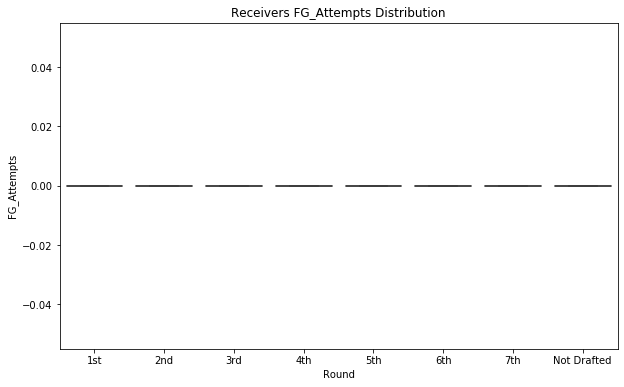

Receivers FG_Percent Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: FG_Percent, dtype: float64
----------------------------------------
Receivers FG_Percent by Round
             FG_Percent
Round                  
1st                0.00
2nd                0.00
3rd                0.00
4th                0.00
5th                0.00
6th                0.00
7th                0.00
Not Drafted        0.00


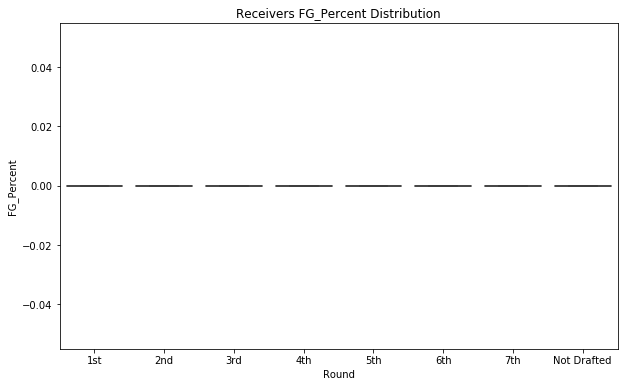

Receivers TTL_Kicking_Points Summary:
count   1812.00
mean       0.00
std        0.02
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: TTL_Kicking_Points, dtype: float64
----------------------------------------
Receivers TTL_Kicking_Points by Round
             TTL_Kicking_Points
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.01
6th                        0.00
7th                        0.00
Not Drafted                0.00


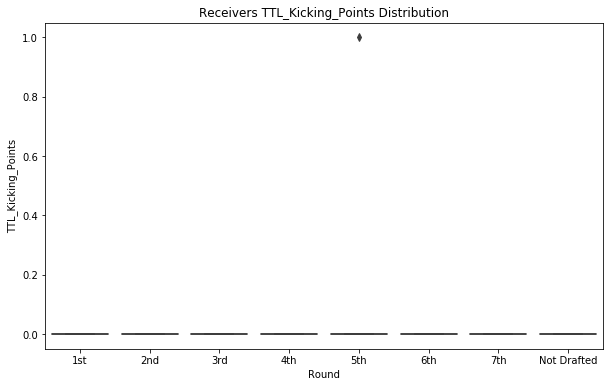

Receivers NumPunts Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: NumPunts, dtype: float64
----------------------------------------
Receivers NumPunts by Round
             NumPunts
Round                
1st              0.00
2nd              0.00
3rd              0.00
4th              0.00
5th              0.00
6th              0.00
7th              0.00
Not Drafted      0.00


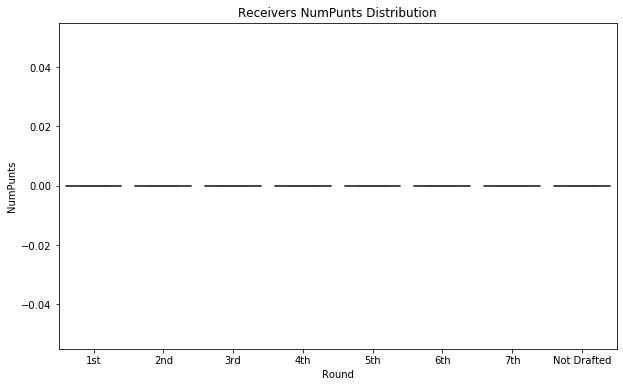

Receivers Punt_Yds Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: Punt_Yds, dtype: float64
----------------------------------------
Receivers Punt_Yds by Round
             Punt_Yds
Round                
1st              0.00
2nd              0.00
3rd              0.00
4th              0.00
5th              0.00
6th              0.00
7th              0.00
Not Drafted      0.00


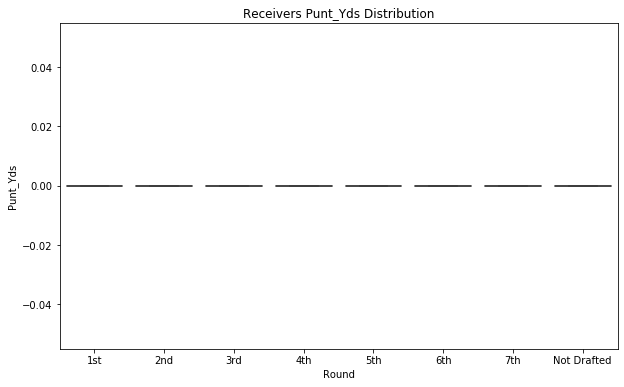

Receivers Yds_per_Punt Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: Yds_per_Punt, dtype: float64
----------------------------------------
Receivers Yds_per_Punt by Round
             Yds_per_Punt
Round                    
1st                  0.00
2nd                  0.00
3rd                  0.00
4th                  0.00
5th                  0.00
6th                  0.00
7th                  0.00
Not Drafted          0.00


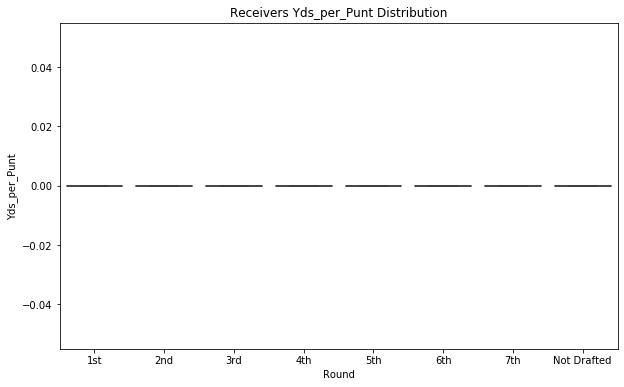

Receivers XP_MadeperGame Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.07
Name: XP_MadeperGame, dtype: float64
----------------------------------------
Receivers XP_MadeperGame by Round
             XP_MadeperGame
Round                      
1st                    0.00
2nd                    0.00
3rd                    0.00
4th                    0.00
5th                    0.00
6th                    0.00
7th                    0.00
Not Drafted            0.00


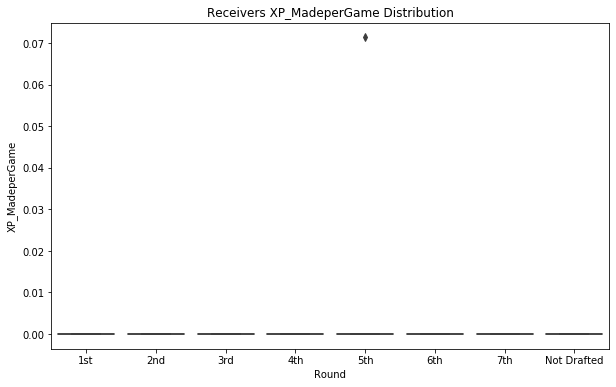

Receivers XP_AttemptsperGame Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.07
Name: XP_AttemptsperGame, dtype: float64
----------------------------------------
Receivers XP_AttemptsperGame by Round
             XP_AttemptsperGame
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


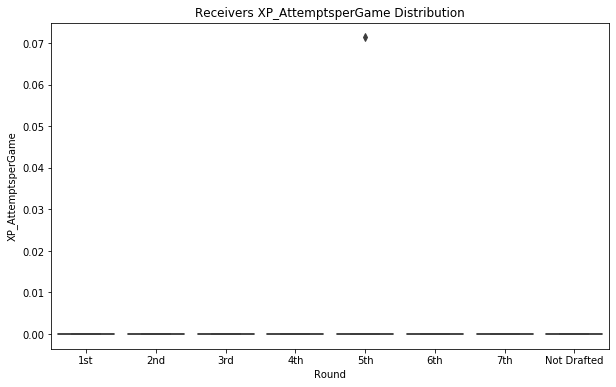

Receivers FG_MadeperGame Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: FG_MadeperGame, dtype: float64
----------------------------------------
Receivers FG_MadeperGame by Round
             FG_MadeperGame
Round                      
1st                    0.00
2nd                    0.00
3rd                    0.00
4th                    0.00
5th                    0.00
6th                    0.00
7th                    0.00
Not Drafted            0.00


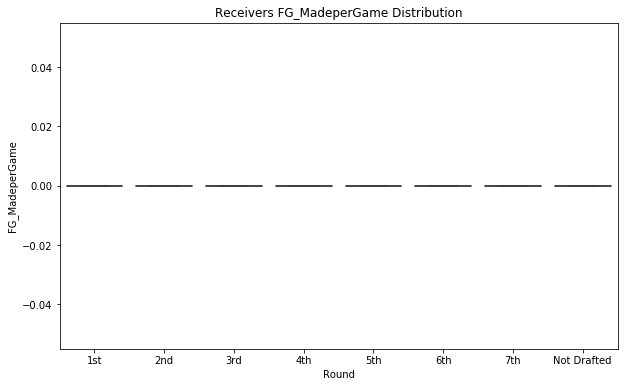

Receivers FG_AttemptsperGame Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: FG_AttemptsperGame, dtype: float64
----------------------------------------
Receivers FG_AttemptsperGame by Round
             FG_AttemptsperGame
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


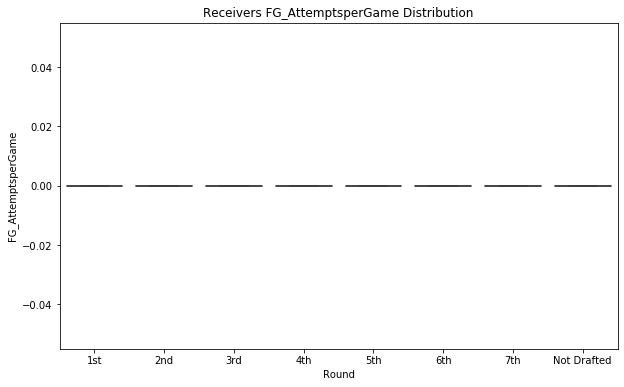

Receivers TTL_Kicking_PointsperGame Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.07
Name: TTL_Kicking_PointsperGame, dtype: float64
----------------------------------------
Receivers TTL_Kicking_PointsperGame by Round
             TTL_Kicking_PointsperGame
Round                                 
1st                               0.00
2nd                               0.00
3rd                               0.00
4th                               0.00
5th                               0.00
6th                               0.00
7th                               0.00
Not Drafted                       0.00


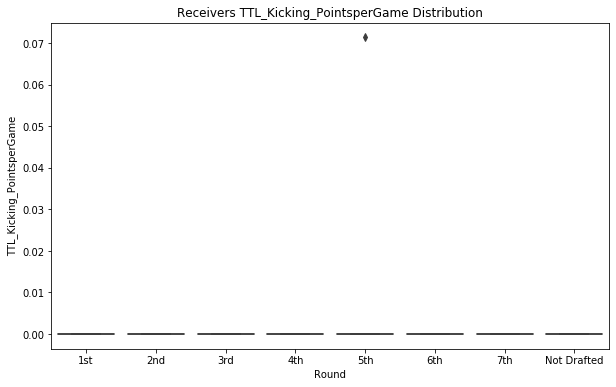

Receivers NumPuntsperGame Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: NumPuntsperGame, dtype: float64
----------------------------------------
Receivers NumPuntsperGame by Round
             NumPuntsperGame
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


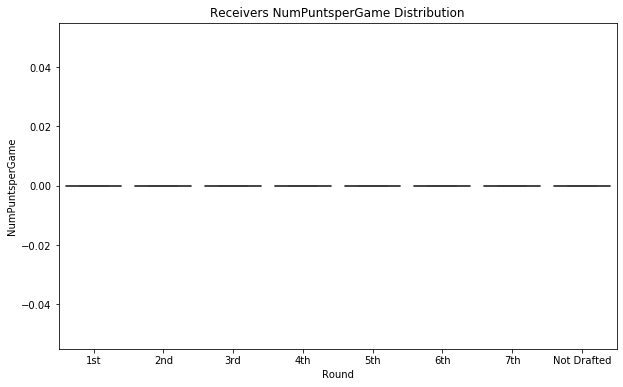

Receivers Punt_YdsperGame Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: Punt_YdsperGame, dtype: float64
----------------------------------------
Receivers Punt_YdsperGame by Round
             Punt_YdsperGame
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


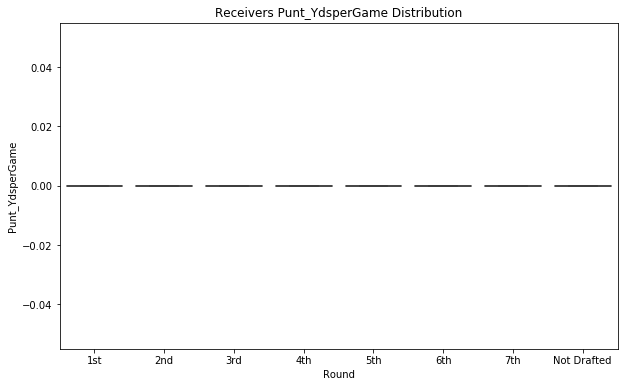

In [37]:
plot_stats('Receivers', receivers_df, kicking_stats)

In [38]:
for i in kicking_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Receivers', receivers_df, i)
    print('')
    print('*' * 40)

Kicking_Games ANOVA Test:
----------------------------------------
              df  sum_sq  mean_sq    F  PR(>F)
Round       7.00    1.13     0.16 0.80    0.59
Residual 1804.00  363.47     0.20  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd      0.0    0.9 -0.1507 0.1507  False
   1st         3rd      0.0    0.9 -0.1484 0.1484  False
   1st         4th      0.0    0.9 -0.1459 0.1459  False
   1st         5th   0.0903 0.6221 -0.0646 0.2453  False
   1st         6th      0.0    0.9 -0.1588 0.1588  False
   1st         7th      0.0    0.9 -0.1535 0.1535  False
   1st Not Drafted   0.0203    0.9 -0.1019 0.1426  False
   2nd         3rd      0.0    0.9 -0.1437 0.1437  False
   2nd         4th      0.0    0.9  -0.141  0.141  False
   2nd         5th   0.0903 0.5903 -0.0601 0.2408  False
   2nd         6th      0.0    0.9 -0.1543 0.1543 


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1s


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.

              df  sum_sq  mean_sq    F  PR(>F)
Round       7.00    0.00     0.00 1.53    0.15
Residual 1804.00    0.01     0.00  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd      0.0    0.9 -0.0006 0.0006  False
   1st         3rd      0.0    0.9 -0.0006 0.0006  False
   1st         4th      0.0    0.9 -0.0005 0.0005  False
   1st         5th   0.0005  0.234 -0.0001  0.001  False
   1st         6th      0.0    0.9 -0.0006 0.0006  False
   1st         7th      0.0    0.9 -0.0006 0.0006  False
   1st Not Drafted      0.0    0.9 -0.0005 0.0005  False
   2nd         3rd      0.0    0.9 -0.0005 0.0005  False
   2nd         4th      0.0    0.9 -0.0005 0.0005  False
   2nd         5th   0.0005 0.2005 -0.0001  0.001  False
   2nd         6th      0.0    0.9 -0.0006 0.0006  False
   2nd         7th      0.0    0.9 -0.0006 0.0006  False
   


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.

### College Stats - Punt Returns

In [39]:
puntret_stats = ['PuntRet_Games', 'Kickoff_Returns', 'KO_Return_Yds', 'Yds_per_KO_Return', 'KO_Returned_for_TD', 
                 'Kickoff_ReturnsperGame', 'KO_Return_YdsperGame', 'KO_Returned_for_TDperGame']

In [40]:
receivers_df[puntret_stats].describe()

,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame
count,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00
mean,2.15,0.46,10.34,1.11,0.00,0.04,0.86,0.00
std,4.64,2.67,64.09,4.83,0.07,0.22,5.30,0.01
min,0.00,0.00,-8.00,-8.00,0.00,0.00,-0.89,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,15.00,32.00,845.00,37.00,2.00,2.46,65.00,0.15


Receivers PuntRet_Games Summary:
count   1812.00
mean       2.15
std        4.64
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       15.00
Name: PuntRet_Games, dtype: float64
----------------------------------------
Receivers PuntRet_Games by Round
             PuntRet_Games
Round                     
1st                   2.95
2nd                   2.40
3rd                   1.99
4th                   2.56
5th                   2.50
6th                   1.75
7th                   1.69
Not Drafted           1.91


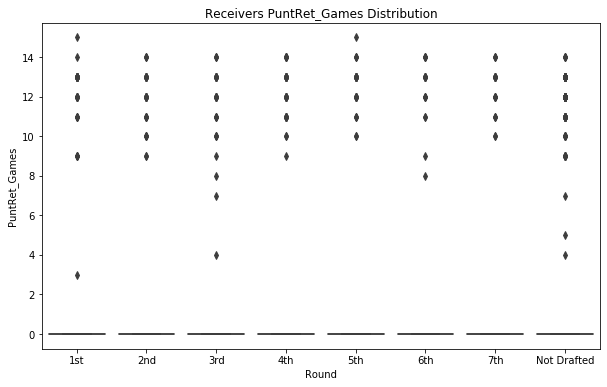

Receivers Kickoff_Returns Summary:
count   1812.00
mean       0.46
std        2.67
min        0.00
25%        0.00
50%        0.00
75%        0.00
max       32.00
Name: Kickoff_Returns, dtype: float64
----------------------------------------
Receivers Kickoff_Returns by Round
             Kickoff_Returns
Round                       
1st                     0.75
2nd                     0.48
3rd                     0.55
4th                     0.63
5th                     1.01
6th                     0.39
7th                     0.13
Not Drafted             0.26


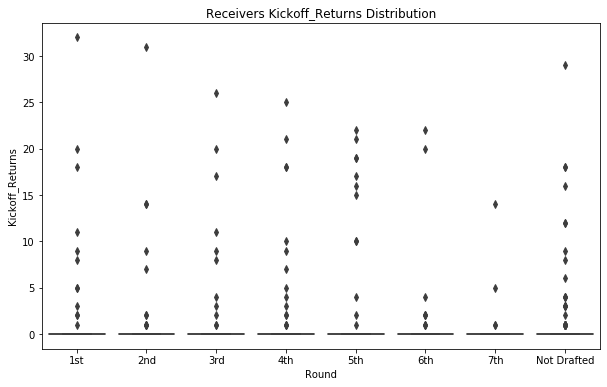

Receivers KO_Return_Yds Summary:
count   1812.00
mean      10.34
std       64.09
min       -8.00
25%        0.00
50%        0.00
75%        0.00
max      845.00
Name: KO_Return_Yds, dtype: float64
----------------------------------------
Receivers KO_Return_Yds by Round
             KO_Return_Yds
Round                     
1st                  17.16
2nd                  10.37
3rd                  12.96
4th                  14.15
5th                  21.78
6th                   9.83
7th                   3.32
Not Drafted           5.83


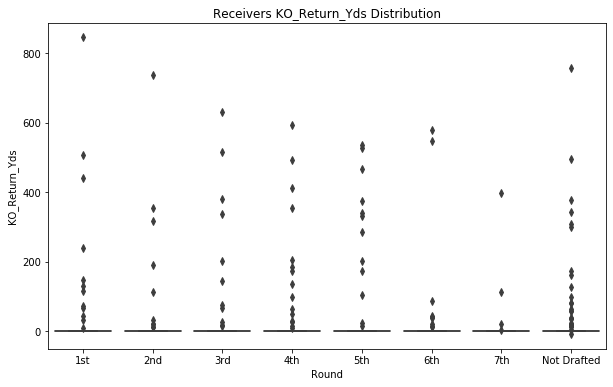

Receivers Yds_per_KO_Return Summary:
count   1812.00
mean       1.11
std        4.83
min       -8.00
25%        0.00
50%        0.00
75%        0.00
max       37.00
Name: Yds_per_KO_Return, dtype: float64
----------------------------------------
Receivers Yds_per_KO_Return by Round
             Yds_per_KO_Return
Round                         
1st                       1.53
2nd                       1.02
3rd                       1.25
4th                       1.62
5th                       1.58
6th                       1.31
7th                       0.47
Not Drafted               0.84


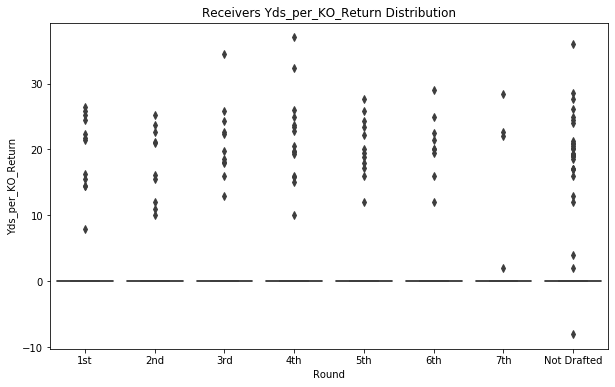

Receivers KO_Returned_for_TD Summary:
count   1812.00
mean       0.00
std        0.07
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        2.00
Name: KO_Returned_for_TD, dtype: float64
----------------------------------------
Receivers KO_Returned_for_TD by Round
             KO_Returned_for_TD
Round                          
1st                        0.01
2nd                        0.00
3rd                        0.02
4th                        0.00
5th                        0.00
6th                        0.01
7th                        0.01
Not Drafted                0.00


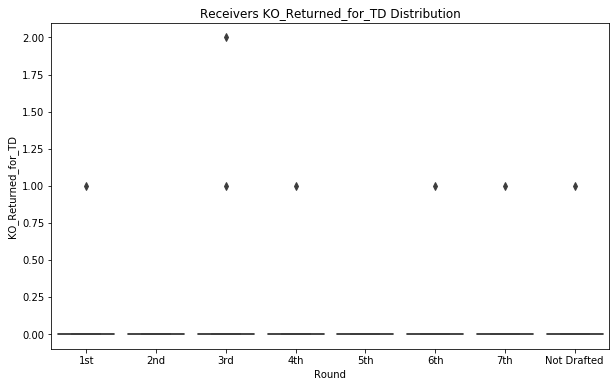

Receivers Kickoff_ReturnsperGame Summary:
count   1812.00
mean       0.04
std        0.22
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        2.46
Name: Kickoff_ReturnsperGame, dtype: float64
----------------------------------------
Receivers Kickoff_ReturnsperGame by Round
             Kickoff_ReturnsperGame
Round                              
1st                            0.06
2nd                            0.04
3rd                            0.05
4th                            0.05
5th                            0.08
6th                            0.03
7th                            0.01
Not Drafted                    0.02


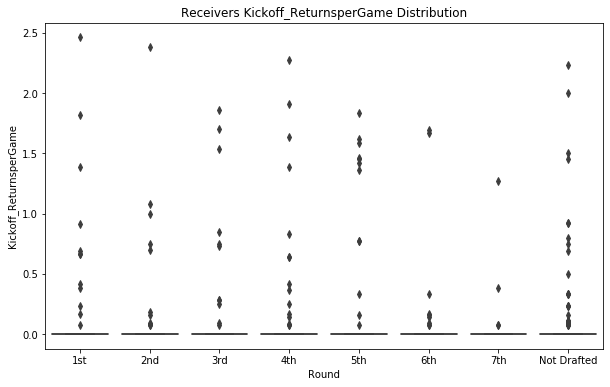

Receivers KO_Return_YdsperGame Summary:
count   1812.00
mean       0.86
std        5.30
min       -0.89
25%        0.00
50%        0.00
75%        0.00
max       65.00
Name: KO_Return_YdsperGame, dtype: float64
----------------------------------------
Receivers KO_Return_YdsperGame by Round
             KO_Return_YdsperGame
Round                            
1st                          1.46
2nd                          0.81
3rd                          1.05
4th                          1.22
5th                          1.79
6th                          0.79
7th                          0.29
Not Drafted                  0.51


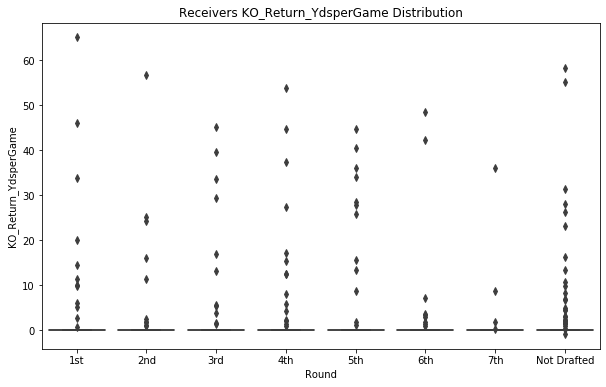

Receivers KO_Returned_for_TDperGame Summary:
count   1812.00
mean       0.00
std        0.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.15
Name: KO_Returned_for_TDperGame, dtype: float64
----------------------------------------
Receivers KO_Returned_for_TDperGame by Round
             KO_Returned_for_TDperGame
Round                                 
1st                               0.00
2nd                               0.00
3rd                               0.00
4th                               0.00
5th                               0.00
6th                               0.00
7th                               0.00
Not Drafted                       0.00


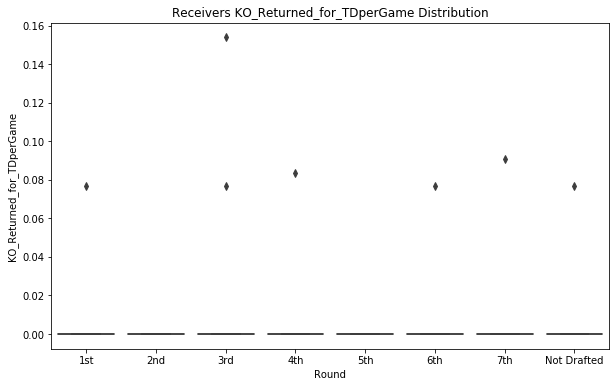

In [41]:
plot_stats('Receivers', receivers_df, puntret_stats)

In [42]:
for i in puntret_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Receivers', receivers_df, i)
    print('')
    print('*' * 40)

PuntRet_Games ANOVA Test:
----------------------------------------
              df   sum_sq  mean_sq    F  PR(>F)
Round       7.00   261.28    37.33 1.74    0.10
Residual 1804.00 38749.55    21.48  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.5522    0.9 -2.1082 1.0037  False
   1st         3rd  -0.9653 0.5367 -2.4975 0.5669  False
   1st         4th  -0.3973    0.9 -1.9034 1.1088  False
   1st         5th  -0.4513    0.9 -2.0514 1.1488  False
   1st         6th  -1.2028 0.3363  -2.842 0.4364  False
   1st         7th  -1.2651 0.2313 -2.8503 0.3201  False
   1st Not Drafted  -1.0436  0.192 -2.3059 0.2187  False
   2nd         3rd  -0.4131    0.9 -1.8963 1.0702  False
   2nd         4th   0.1549    0.9 -1.3013 1.6112  False
   2nd         5th   0.1009    0.9 -1.4524 1.6542  False
   2nd         6th  -0.6505    0.9 -2.2441  0.9

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0065    0.9 -0.0314 0.0184  False
   1st         3rd   0.0096    0.9 -0.0149 0.0342  False
   1st         4th  -0.0015    0.9 -0.0256 0.0226  False
   1st         5th  -0.0065    0.9 -0.0321 0.0191  False
   1st         6th   0.0006    0.9 -0.0256 0.0268  False
   1st         7th  -0.0003    0.9 -0.0257 0.0251  False
   1st Not Drafted  -0.0049    0.9 -0.0251 0.0153  False
   2nd         3rd   0.0161 0.4431 -0.0076 0.0399  False
   2nd         4th    0.005    0.9 -0.0183 0.0283  False
   2nd         5th      0.0    0.9 -0.0249 0.0249  False
   2nd         6th   0.0071    0.9 -0.0184 0.0326  False
   2nd         7th   0.0062    0.9 -0.0184 0.0308  False
   2nd Not Drafted   0.0016    0.9 -0.0177 0.0208  False
   3rd         4th  -0.0112 0.7957 -0.0341 0.0117  False
   3rd         5th  -0.0161 0.4

### College Stats - Scoring

In [43]:
scoring_stats = ['Scoring_Games', 'TD_Other', 'Ttl_TDs', 'TwoPT_Conversion', 'Safety', 'TTL_Points', 'TD_OtherperGame',
                 'Ttl_TDsperGame', 'TwoPT_ConversionperGame', 'SafetyperGame', 'TTL_PointsperGame']

In [45]:
receivers_df[scoring_stats].describe()

,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,TD_OtherperGame,Ttl_TDsperGame,TwoPT_ConversionperGame,SafetyperGame,TTL_PointsperGame
count,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00,1812.00
mean,11.59,-0.00,7.87,0.01,0.00,47.24,-0.00,0.66,0.00,0.00,3.99
std,2.25,0.05,5.64,0.10,0.00,33.84,0.00,0.45,0.01,0.00,2.72
min,0.00,-1.00,0.00,0.00,0.00,0.00,-0.09,0.00,0.00,0.00,0.00
25%,11.00,0.00,4.00,0.00,0.00,24.00,0.00,0.33,0.00,0.00,2.00
50%,12.00,0.00,7.00,0.00,0.00,42.00,0.00,0.58,0.00,0.00,3.50
75%,13.00,0.00,11.00,0.00,0.00,66.00,0.00,0.92,0.00,0.00,5.54
max,15.00,0.00,32.00,2.00,0.00,192.00,0.00,3.00,0.15,0.00,18.00


Receivers Scoring_Games Summary:
count   1812.00
mean      11.59
std        2.25
min        0.00
25%       11.00
50%       12.00
75%       13.00
max       15.00
Name: Scoring_Games, dtype: float64
----------------------------------------
Receivers Scoring_Games by Round
             Scoring_Games
Round                     
1st                  12.12
2nd                  12.20
3rd                  11.47
4th                  11.72
5th                  11.75
6th                  11.87
7th                  11.57
Not Drafted          11.20


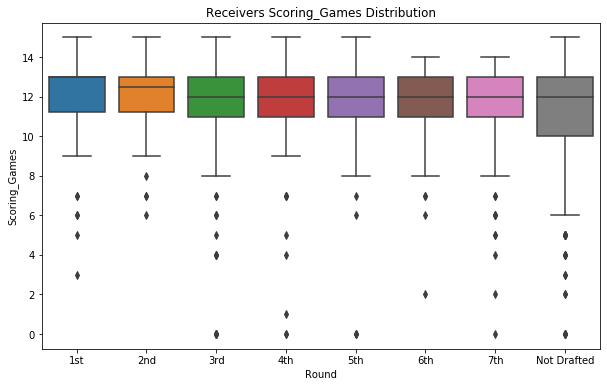

Receivers TD_Other Summary:
count   1812.00
mean      -0.00
std        0.05
min       -1.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: TD_Other, dtype: float64
----------------------------------------
Receivers TD_Other by Round
             TD_Other
Round                
1st             -0.01
2nd              0.00
3rd             -0.01
4th             -0.00
5th              0.00
6th              0.00
7th              0.00
Not Drafted     -0.00


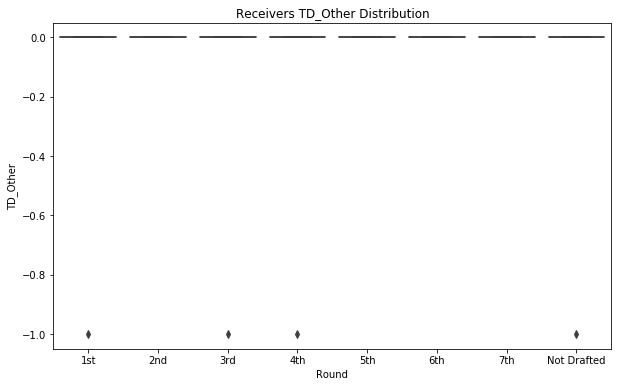

Receivers Ttl_TDs Summary:
count   1812.00
mean       7.87
std        5.64
min        0.00
25%        4.00
50%        7.00
75%       11.00
max       32.00
Name: Ttl_TDs, dtype: float64
----------------------------------------
Receivers Ttl_TDs by Round
             Ttl_TDs
Round               
1st            12.34
2nd            10.61
3rd             8.76
4th             8.27
5th             7.38
6th             7.44
7th             6.50
Not Drafted     6.22


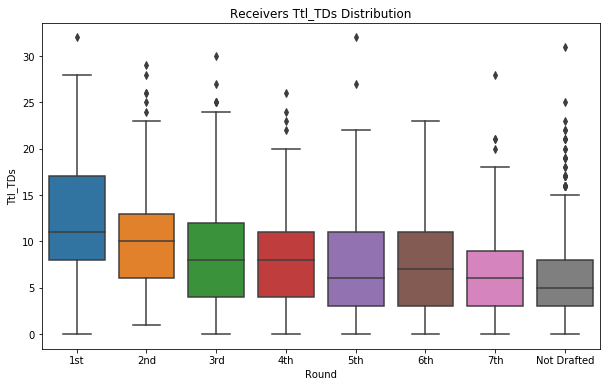

Receivers TwoPT_Conversion Summary:
count   1812.00
mean       0.01
std        0.10
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        2.00
Name: TwoPT_Conversion, dtype: float64
----------------------------------------
Receivers TwoPT_Conversion by Round
             TwoPT_Conversion
Round                        
1st                      0.01
2nd                      0.00
3rd                      0.01
4th                      0.02
5th                      0.01
6th                      0.00
7th                      0.00
Not Drafted              0.01


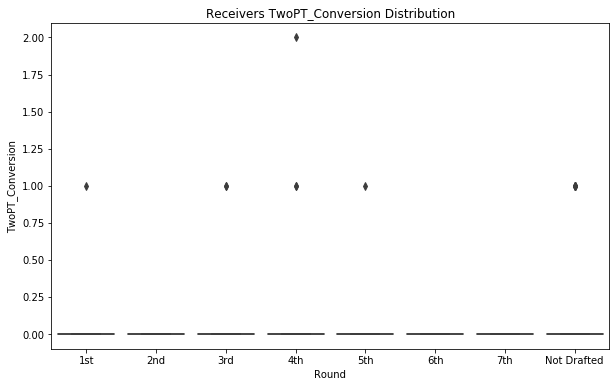

Receivers Safety Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: Safety, dtype: float64
----------------------------------------
Receivers Safety by Round
             Safety
Round              
1st            0.00
2nd            0.00
3rd            0.00
4th            0.00
5th            0.00
6th            0.00
7th            0.00
Not Drafted    0.00


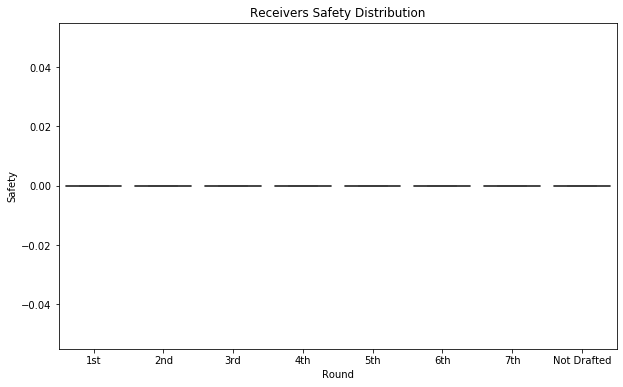

Receivers TTL_Points Summary:
count   1812.00
mean      47.24
std       33.84
min        0.00
25%       24.00
50%       42.00
75%       66.00
max      192.00
Name: TTL_Points, dtype: float64
----------------------------------------
Receivers TTL_Points by Round
             TTL_Points
Round                  
1st               74.04
2nd               63.66
3rd               52.60
4th               49.74
5th               44.30
6th               44.64
7th               39.02
Not Drafted       37.33


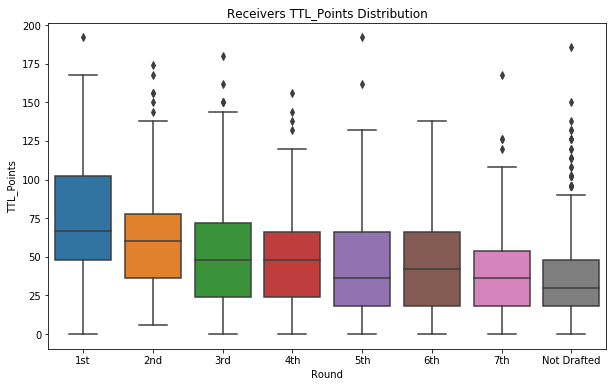

Receivers TD_OtherperGame Summary:
count   1812.00
mean      -0.00
std        0.00
min       -0.09
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: TD_OtherperGame, dtype: float64
----------------------------------------
Receivers TD_OtherperGame by Round
             TD_OtherperGame
Round                       
1st                    -0.00
2nd                     0.00
3rd                    -0.00
4th                    -0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted            -0.00


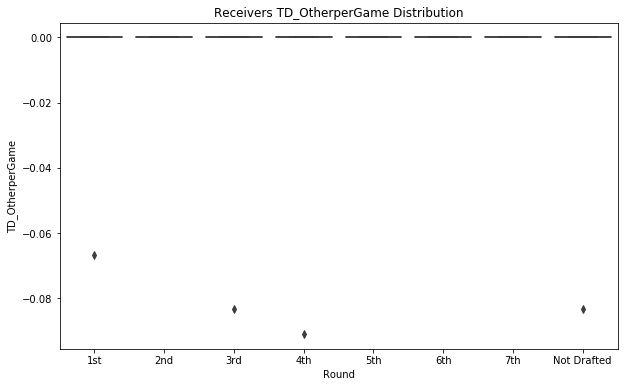

Receivers Ttl_TDsperGame Summary:
count   1812.00
mean       0.66
std        0.45
min        0.00
25%        0.33
50%        0.58
75%        0.92
max        3.00
Name: Ttl_TDsperGame, dtype: float64
----------------------------------------
Receivers Ttl_TDsperGame by Round
             Ttl_TDsperGame
Round                      
1st                    1.02
2nd                    0.86
3rd                    0.72
4th                    0.71
5th                    0.61
6th                    0.63
7th                    0.55
Not Drafted            0.54


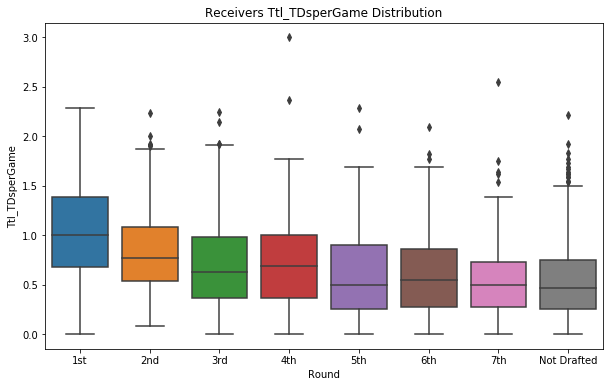

Receivers TwoPT_ConversionperGame Summary:
count   1812.00
mean       0.00
std        0.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.15
Name: TwoPT_ConversionperGame, dtype: float64
----------------------------------------
Receivers TwoPT_ConversionperGame by Round
             TwoPT_ConversionperGame
Round                               
1st                             0.00
2nd                             0.00
3rd                             0.00
4th                             0.00
5th                             0.00
6th                             0.00
7th                             0.00
Not Drafted                     0.00


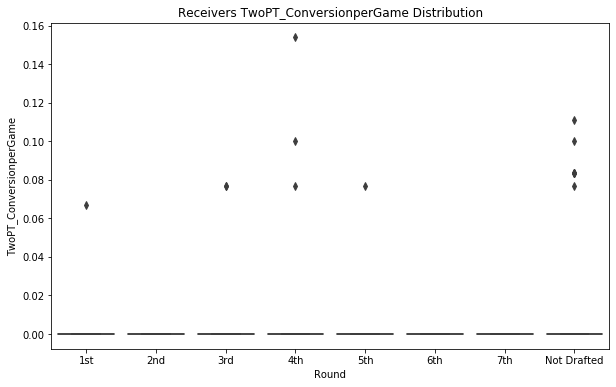

Receivers SafetyperGame Summary:
count   1812.00
mean       0.00
std        0.00
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        0.00
Name: SafetyperGame, dtype: float64
----------------------------------------
Receivers SafetyperGame by Round
             SafetyperGame
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


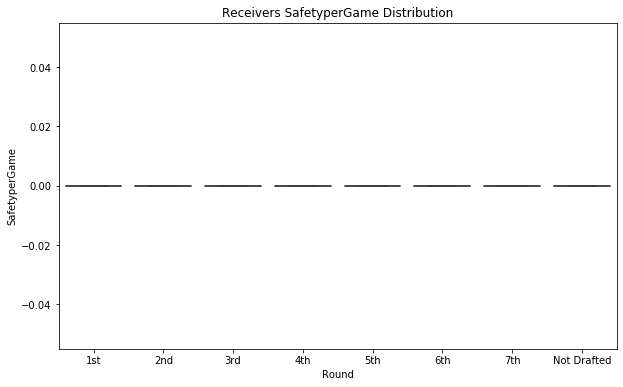

Receivers TTL_PointsperGame Summary:
count   1812.00
mean       3.99
std        2.72
min        0.00
25%        2.00
50%        3.50
75%        5.54
max       18.00
Name: TTL_PointsperGame, dtype: float64
----------------------------------------
Receivers TTL_PointsperGame by Round
             TTL_PointsperGame
Round                         
1st                       6.13
2nd                       5.18
3rd                       4.33
4th                       4.25
5th                       3.65
6th                       3.77
7th                       3.32
Not Drafted               3.26


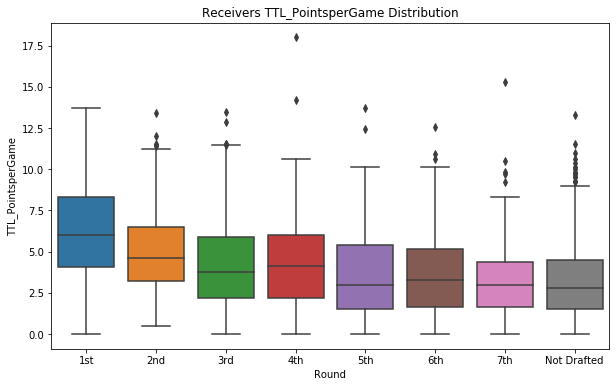

In [48]:
plot_stats('Receivers', receivers_df, scoring_stats)

In [49]:
for i in scoring_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Receivers', receivers_df, i)
    print('')
    print('*' * 40)

Scoring_Games ANOVA Test:
----------------------------------------
              df  sum_sq  mean_sq    F  PR(>F)
Round       7.00  228.08    32.58 6.59    0.00
Residual 1804.00 8918.07     4.94  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd   0.0843    0.9 -0.6622  0.8307  False
   1st         3rd  -0.6491 0.1289 -1.3842  0.0859  False
   1st         4th  -0.3955 0.6864  -1.118   0.327  False
   1st         5th  -0.3685 0.8084 -1.1361  0.3991  False
   1st         6th  -0.2445    0.9 -1.0309  0.5418  False
   1st         7th  -0.5455 0.3677 -1.3059   0.215  False
   1st Not Drafted    -0.92  0.001 -1.5256 -0.3145   True
   2nd         3rd  -0.7334 0.0379  -1.445 -0.0218   True
   2nd         4th  -0.4798 0.4285 -1.1784  0.2189  False
   2nd         5th  -0.4528 0.5773 -1.1979  0.2924  False
   2nd         6th  -0.3288 0.8989 -1

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5

              df  sum_sq  mean_sq    F  PR(>F)
Round       7.00    0.00     0.00 1.06    0.39
Residual 1804.00    0.12     0.00  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0004    0.9 -0.0031 0.0023  False
   1st         3rd   0.0004    0.9 -0.0023 0.0031  False
   1st         4th   0.0012 0.8367 -0.0014 0.0038  False
   1st         5th   0.0001    0.9 -0.0027 0.0028  False
   1st         6th  -0.0004    0.9 -0.0033 0.0024  False
   1st         7th  -0.0004    0.9 -0.0032 0.0023  False
   1st Not Drafted   0.0005    0.9 -0.0017 0.0027  False
   2nd         3rd   0.0008    0.9 -0.0017 0.0034  False
   2nd         4th   0.0016 0.4971 -0.0009 0.0042  False
   2nd         5th   0.0005    0.9 -0.0022 0.0032  False
   2nd         6th      0.0    0.9 -0.0028 0.0028  False
   2nd         7th      0.0    0.9 -0.0027 0.0027  False
   